# DSPy 3.0.3 Medical Data Extraction Pipeline

This notebook demonstrates a comprehensive data extraction pipeline using DSPy 3.0.3 to extract structured trail characteristics from medical research papers in markdown format.

## Objective
Extract structured data from medical research markdown  into the target format matching `trail_characteristics.json`.


In [25]:
import os
import shutil

cache_dir = "./"  # or wherever you set it

# Remove cache directories (not files)
cache_dirs = [".semantic_cache", ".evaluation_cache"]

for cache_name in cache_dirs:
    cache_path = os.path.join(cache_dir, cache_name)
    if os.path.exists(cache_path):
        shutil.rmtree(cache_path)  # ← Use rmtree for directories
        print(f"Cleared {cache_path}")
    else:
        print(f"{cache_path} doesn't exist") 

./.semantic_cache doesn't exist
./.evaluation_cache doesn't exist


## 1. Setup and Dependencies


In [26]:
import dspy
import json
import pandas as pd
import numpy as np
import re
import os
from typing import List, Dict, Any, Optional, Tuple
from dataclasses import dataclass
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics.pairwise import cosine_similarity
import warnings
import asyncio
from datetime import datetime
import aiofiles
import traceback
import math

import tiktoken
from sentence_transformers import SentenceTransformer
from dotenv import load_dotenv
import hashlib
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import cohen_kappa_score
import diskcache as dc

# Suppress warnings
warnings.filterwarnings('ignore')

# Load environment variables
load_dotenv()

# Print DSPy version

True

## 2. Configure DSPy Language Model


In [27]:
# Set your API key (uncomment and add your key)
# os.environ["OPENAI_API_KEY"] = "your-api-key-here"

# Configure DSPy with OpenAI GPT-4o-mini for cost efficiency
lm = dspy.LM('gemini/gemini-2.5-pro', max_tokens=20000, temperature=1.0)
#lm = dspy.LM('openai/gpt-5-mini-2025-08-07', max_tokens=20000, temperature=1.0)
#lm = dspy.LM("anthropic/claude-sonnet-4-5-20250929" , max_tokens=20000, temperature=1.0)
dspy.configure(lm=lm)

print("Language model configured successfully")


Language model configured successfully


### DSpy History Details


In [28]:
# Global variables to track processed calls
_processed_hashes = set()
_csv_path = "dspy_history.csv"

def set_log_file(csv_path: str):
    """Set the CSV file path for logging."""
    global _csv_path, _processed_hashes
    _csv_path = csv_path
    
    # Load existing hashes from CSV if it exists
    if Path(csv_path).exists():
        try:
            df = pd.read_csv(csv_path)
            if 'call_hash' in df.columns:
                _processed_hashes = set(df['call_hash'].tolist())
                print(f"Loaded {len(_processed_hashes)} existing records from {csv_path}")
        except Exception as e:
            print(f"Warning: Could not load existing CSV: {e}")
    else:
        print(f"New log file will be created: {csv_path}")

def log_history():
    """Log current DSPy history to CSV. Call this after running DSPy operations."""
    global _processed_hashes, _csv_path
    
    # Get LM from dspy settings
    try:
        lm = dspy.settings.lm
    except:
        print("Error: No LM found in dspy.settings")
        return 0
    
    if not hasattr(lm, 'history') or not lm.history:
        print("No history found in language model")
        return 0
    
    new_records = []
    
    for call_data in lm.history:
        # Generate unique hash
        hash_content = {
            'messages': call_data.get('messages', []),
            'timestamp': call_data.get('timestamp', ''),
            'uuid': call_data.get('uuid', ''),
        }
        call_hash = hashlib.md5(json.dumps(hash_content, sort_keys=True, default=str).encode()).hexdigest()
        
        # Skip if already processed
        if call_hash in _processed_hashes:
            continue
        
        # Extract call info
        messages = call_data.get('messages', [])
        system_msg = next((m.get('content', '') for m in messages if m.get('role') == 'system'), '')
        user_msg = next((m.get('content', '') for m in messages if m.get('role') == 'user'), '')
        
        # Extract response
        response_obj = call_data.get('response', {})
        assistant_response = ""
        if hasattr(response_obj, 'choices') and response_obj.choices:
            assistant_response = response_obj.choices[0].message.content
        
        # Extract usage
        usage = call_data.get('usage', {})
        if isinstance(usage, dict):
            prompt_tokens = usage.get('prompt_tokens', 0)
            completion_tokens = usage.get('completion_tokens', 0) 
            total_tokens = usage.get('total_tokens', 0)
        else:
            prompt_tokens = completion_tokens = total_tokens = 0
        
        record = {
            'call_hash': call_hash,
            'timestamp': call_data.get('timestamp', datetime.now().isoformat()),
            'uuid': call_data.get('uuid', ''),
            'model': call_data.get('model', ''),
            'cost': call_data.get('cost', 0.0),
            'prompt_tokens': prompt_tokens,
            'completion_tokens': completion_tokens,
            'total_tokens': total_tokens,
            'system_msg_length': len(system_msg),
            'user_msg_preview': user_msg[:200] if user_msg else '',
            'response_preview': assistant_response[:200] if assistant_response else '',
            'cache_hit': getattr(response_obj, 'cache_hit', False) if response_obj else False,
            'logged_at': datetime.now().isoformat()
        }
        
        new_records.append(record)
        _processed_hashes.add(call_hash)
    
    if not new_records:
        print("No new records to add")
        return 0
    
    # Save to CSV
    new_df = pd.DataFrame(new_records)
    
    if Path(_csv_path).exists():
        new_df.to_csv(_csv_path, mode='a', header=False, index=False)
    else:
        Path(_csv_path).parent.mkdir(parents=True, exist_ok=True)
        new_df.to_csv(_csv_path, index=False)
    
    return len(new_records)

def show_stats():
    """Show statistics from the logged history."""
    global _csv_path
    
    if not Path(_csv_path).exists():
        print("No history file found")
        return
    
    try:
        df = pd.read_csv(_csv_path)
        
        print(f"\nDSPy History Stats from {_csv_path}:")
        print("=" * 50)
        print(f"Total calls: {len(df)}")
        
        if 'model' in df.columns:
            print(f"Unique models: {df['model'].nunique()}")
            print("Model breakdown:")
            for model, count in df['model'].value_counts().head().items():
                print(f"  {model}: {count} calls")
        
        if 'cost' in df.columns:
            # If prompt_tokens == 0, set cost = 0 for those rows
            df.loc[df['prompt_tokens'] == 0, 'cost'] = 0

            # Recompute totals
            total_cost = df['cost'].sum()
            avg_cost = df['cost'].mean()

            print(f"Total cost: ${total_cost:.4f}")
            print(f"Average cost per call: ${avg_cost:.4f}")

        
        if 'total_tokens' in df.columns:
            total_tokens = df['total_tokens'].sum()
            avg_tokens = df['total_tokens'].mean()
            print(f"Total tokens: {total_tokens:,}")
            print(f"Average tokens per call: {avg_tokens:.1f}")
        
        if 'cache_hit' in df.columns:
            cache_rate = df['cache_hit'].mean() * 100
            print(f"Cache hit rate: {cache_rate:.1f}%")
        
        if 'timestamp' in df.columns:
            print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
        
    except Exception as e:
        print(f"Error reading history: {e}")

def view_recent(n=5):
    """View the most recent n logged calls."""
    global _csv_path
    
    if not Path(_csv_path).exists():
        print("No history file found")
        return
    
    try:
        df = pd.read_csv(_csv_path)
        recent = df.tail(n)
        
        print(f"\nMost Recent {n} DSPy Calls:")
        print("=" * 60)
        
        for _, row in recent.iterrows():
            print(f"Time: {row['timestamp']}")
            print(f"Model: {row['model']}")
            print(f"Tokens: {row['total_tokens']} | Cost: ${row['cost']:.4f}")
            print(f"User: {row['user_msg_preview'][:100]}...")
            print(f"Response: {row['response_preview'][:100]}...")
            print("-" * 40)
            
    except Exception as e:
        print(f"Error reading history: {e}")

def clear_cache():
    """Clear the processed hashes cache (will reprocess all history next time)."""
    global _processed_hashes
    _processed_hashes.clear()
    print("Cleared processed hashes cache")

def export_full_history(output_file: str = "full_dspy_history.json"):
    """Export complete DSPy history with full messages to JSON."""
    try:
        lm = dspy.settings.lm
        if hasattr(lm, 'history') and lm.history:
            with open(output_file, 'w') as f:
                json.dump(lm.history, f, indent=2, default=str)
            print(f"Exported full history to {output_file}")
        else:
            print("No history found to export")
    except Exception as e:
        print(f"Error exporting history: {e}")

# Initialize with default file
set_log_file("dspy_history.csv")

print("DSPy History Logger for Notebooks Ready!")
print("Usage:")
print("  set_log_file('my_file.csv')  # Set custom log file")
print("  log_history()                # Log current DSPy history") 
print("  show_stats()                 # Show summary statistics")
print("  view_recent(5)               # View recent 5 calls")
print("  clear_cache()                # Clear processed cache")
print("  export_full_history()        # Export complete history to JSON")

# Cell 1: Set your log file
set_log_file("/nlp/data/karthik9/Sprint1/Dental/Data/csvs/extraction_history.csv")

New log file will be created: dspy_history.csv
DSPy History Logger for Notebooks Ready!
Usage:
  set_log_file('my_file.csv')  # Set custom log file
  log_history()                # Log current DSPy history
  show_stats()                 # Show summary statistics
  view_recent(5)               # View recent 5 calls
  clear_cache()                # Clear processed cache
  export_full_history()        # Export complete history to JSON
Loaded 40023 existing records from /nlp/data/karthik9/Sprint1/Dental/Data/csvs/extraction_history.csv


In [29]:
#Log the history  
log_history()

#Check stats anytime
show_stats()

No history found in language model

DSPy History Stats from /nlp/data/karthik9/Sprint1/Dental/Data/csvs/extraction_history.csv:
Total calls: 40106
Unique models: 4
Model breakdown:
  gemini/gemini-2.5-pro: 34610 calls
  openai/gpt-4o-mini: 5434 calls
  openai/gpt-5-mini-2025-08-07: 58 calls
  openai/gpt-5-2025-08-07: 4 calls
Total cost: $91.9921
Average cost per call: $0.0023
Total tokens: 22,450,769
Average tokens per call: 559.8
Cache hit rate: 76.0%
Date range: 2025-09-16T10:33:45.131530 to 2025-11-13T12:25:34.140432


### Safe Json Parser

In [30]:
def safe_json_parse(json_string, fallback=None):
    """Robust JSON parser with multiple recovery strategies."""
    if fallback is None:
        fallback = {}
    
    if not json_string or not isinstance(json_string, str):
        return fallback
    
    # Clean markdown fences first
    import re
    json_string = re.sub(r"```[a-zA-Z]*\n?", "", json_string).replace("```", "")
    json_string = json_string.strip()
    
    # Strategy 1: Direct parsing
    try:
        result = json.loads(json_string)
        if isinstance(result, str) and result.strip().startswith(("{", "[")):
            return safe_json_parse(result, fallback)
        return result
    except json.JSONDecodeError:
        pass
    
    # Strategy 2: Clean common issues and handle nested single quotes
    try:
        cleaned = json_string.strip()
        cleaned = cleaned.replace('\n', '\\n').replace('\r', '\\r').replace('\t', '\\t')
        cleaned = re.sub(r',(\s*[}\]])', r'\1', cleaned)
        
        if cleaned.startswith("'") or "': '" in cleaned or "': {'" in cleaned:
            cleaned = cleaned.replace("'", '"')
            cleaned = cleaned.replace('""', '"')
        else:
            cleaned = re.sub(r"'([^']*)':", r'"\1":', cleaned)
            cleaned = re.sub(r":\s*'([^']*)'", r': "\1"', cleaned)
        
        result = safe_json_parse(cleaned)
        if isinstance(result, str) and result.strip().startswith(("{", "[")):
            return safe_json_parse(result, fallback)
        return result
    except (json.JSONDecodeError, AttributeError):
        pass
    
    # Strategy 3: Extract key-value pairs manually
    try:
        data = {}
        for match in re.finditer(r'"([^"]+)":\s*(\d+(?:\.\d+)?)', json_string):
            key, value = match.groups()
            data[key] = float(value) if '.' in value else int(value)
        
        for match in re.finditer(r'"([^"]+)":\s*"([^"]*)"', json_string):
            key, value = match.groups()
            data[key] = value
        
        for match in re.finditer(r'"([^"]+)":\s*(true|false)', json_string):
            key, value = match.groups()
            data[key] = value == 'true'
        
        if data:
            return data
    except:
        pass
    
    return fallback


## 3. Data Loading and Exploration


In [31]:
# Load source file
source_file = "/nlp/data/karthik9/Sprint1/Dental/Data/oral_cancer_mds/Agrawal_2024_md/Agrawal_2024_md.json"
target_file = "/nlp/data/karthik9/Sprint1/Dental/Data/oral_cancer_jsons/patient_population_characteristics1.json"

with open(source_file, 'r') as f:
    source_data = json.load(f)

with open(target_file, 'r') as f:
    target_data = json.load(f)



# Extract markdown content
markdown_content = source_data['marker']['markdown']

# Use OpenAI tokenizer (cl100k_base is the same one GPT-4/4o/5 use)
encoding = tiktoken.get_encoding("cl100k_base")
tokens = encoding.encode(markdown_content)

print(f"Markdown content length: {len(markdown_content)} characters")
print(f"Token count: {len(tokens)}")
print(f"Target data contains {len(target_data)} records")

Markdown content length: 30906 characters
Token count: 7507
Target data contains 39 records


In [32]:
# Filter target data for  study to understand expected output
one_study_records = [record for record in target_data if record.get('filename') == 'Agrawal_2024']
print(f"Found {len(one_study_records)} records in target data")

# Show example record structure
if one_study_records:
    print("\nExample target record structure:")
    for key, value in one_study_records[0].items():
        print(f"{key}: {value}")


Found 1 records in target data

Example target record structure:
population: {'innocuous_lesions': {'selected': False, 'comment': ''}, 'suspicious_or_malignant_lesions': {'selected': True, 'comment': 'patients who exhibited symptoms of oral premalignant lesions or suspected oral malignancy'}, 'healthy_without_lesions': {'selected': False, 'comment': ''}, 'other': {'selected': False, 'comment': ''}, 'unclear': {'selected': False, 'comment': ''}, 'statement': 'Patients with clinically evident suspicious lesions or seemingly malignant lesions in the oral cavity or lips'}
patient_selection_method: NR
100 patients of all age groups from the ENT OPD who exhibited symptoms of oral premalignant lesions or suspected oral malignancy.
population_ses: Most participants (77.0%) were from rural areas, 23% from urban areas.
population_ethnicity: NR
population_risk_factors: Smokeless tobacco 87(87%); alcohol 37(37%); betel nut 56(56%); and smoking tobacco 39(39%) [total n=100, patients with multiple h

## 4. MedicalFileHandler & Plots


In [33]:
import asyncio
import json
import aiofiles
import pandas as pd
from pathlib import Path
from datetime import datetime
from typing import List, Dict, Any



class AsyncMedicalFileHandler:
    """Async file handler for medical data extraction pipeline."""
    
    def __init__(self, default_output_dir: str = None, default_csv_dir: str = "/nlp/data/karthik9/Sprint1/Dental/Data/csvs", 
                 default_json_path: str = "/nlp/data/karthik9/Sprint1/Dental/Data/ev_jsons/patient_population_evaluation_results.json"):
        self.default_output_dir = default_output_dir
        self.default_csv_dir = default_csv_dir
        self.default_json_path = default_json_path
    
    def _generate_output_filename(self, source_file_path: str) -> str:
        """Generate output filename from source filename."""
        source_path = Path(source_file_path)
        source_name = source_path.stem
        
        if source_name.endswith('_md'):
            output_name = source_name[:-3] + '_patient_population'
        else:
            output_name = source_name + '_patient_population'
        
        return output_name + '.json'
    
    async def save_extracted_results(self, extracted_records: List[Dict], 
                                   source_file_path: str, 
                                   output_dir: str = None, 
                                   override: bool = False) -> str:
        """Save extracted results to JSON file asynchronously."""
        try:
            output_filename = self._generate_output_filename(source_file_path)
            
            if output_dir is None:
                if self.default_output_dir:
                    output_dir = Path(self.default_output_dir)
                else:
                    output_dir = Path(source_file_path).parent
            else:
                output_dir = Path(output_dir)
            
            output_dir.mkdir(parents=True, exist_ok=True)
            output_path = output_dir / output_filename
            
            if output_path.exists() and not override:
                #print(f"Output file already exists: {output_path}")
                return None
            
            save_data = {
                "metadata": {
                    "source_file": str(source_file_path),
                    "extraction_timestamp": datetime.now().isoformat(),
                    "total_records": len(extracted_records),
                    "pipeline_version": "DSPy_Async_1.0"
                },
                "extracted_records": extracted_records
            }
            
            async with aiofiles.open(output_path, 'w', encoding='utf-8') as f:
                await f.write(json.dumps(save_data, indent=2, ensure_ascii=False))
            
            print(f"Successfully saved {len(extracted_records)} records to: {output_path}")
            return str(output_path)
            
        except Exception as e:
            print(f"Error saving results: {e}")
            return None
    
    async def save_evaluation_to_csv(self, baseline_results: List[Dict], ground_truth: List[Dict], 
                                   source_file: str, matches: List[tuple], csv_dir: str = None, 
                                   override: bool = False):
        """Save evaluation results to CSV asynchronously."""
        csv_dir = csv_dir or self.default_csv_dir
        Path(csv_dir).mkdir(parents=True, exist_ok=True)
        csv_path = Path(csv_dir) / "patient_population_evaluation_results.csv"
        
        # Prepare data rows
        rows = []
        matched_gt_indices = set()
        matched_ext_indices = set()
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        
        # Add matched pairs (TP) - FIXED: Process ground truth and extracted separately but consecutively
        for ext_idx, gt_idx, score in matches:
            if score >= 0.5:
                matched_gt_indices.add(gt_idx)
                matched_ext_indices.add(ext_idx)
                
                # Ground truth row (TP - correctly found)
                gt_row = ground_truth[gt_idx].copy()
                gt_row.update({
                    'data_type': 'ground_truth', 
                    'source_file': source_file,
                    'match_score': score, 
                    'pair_id': f"{source_file}_{gt_idx}",
                    'classification': 'TP', 
                    'timestamp': timestamp
                })
                rows.append(gt_row)
                
                # Extracted row (TP - correct extraction)
                ext_row = baseline_results[ext_idx].copy()
                ext_row.update({
                    'data_type': 'extracted', 
                    'source_file': source_file,
                    'match_score': score, 
                    'pair_id': f"{source_file}_{gt_idx}",
                    'classification': 'TP', 
                    'timestamp': timestamp
                })
                rows.append(ext_row)
        
        # Add unmatched ground truth (FN)
        for gt_idx, gt_record in enumerate(ground_truth):
            if gt_idx not in matched_gt_indices:
                row = gt_record.copy()
                row.update({
                    'data_type': 'ground_truth', 
                    'source_file': source_file,
                    'match_score': 0.0, 
                    'pair_id': f"{source_file}_{gt_idx}_missing",
                    'classification': 'FN', 
                    'timestamp': timestamp
                })
                rows.append(row)
        
        # Add unmatched extractions (FP)
        for ext_idx, ext_record in enumerate(baseline_results):
            if ext_idx not in matched_ext_indices:
                row = ext_record.copy()
                row.update({
                    'data_type': 'extracted', 
                    'source_file': source_file,
                    'match_score': 0.0, 
                    'pair_id': f"{source_file}_fp_{ext_idx}",
                    'classification': 'FP', 
                    'timestamp': timestamp
                })
                rows.append(row)
        
        # Save to CSV asynchronously
        new_df = pd.DataFrame(rows)
        
        if not new_df.empty:
            
            if csv_path.exists() and not override:
                # Load existing data asynchronously
                async with aiofiles.open(csv_path, 'r') as f:
                    content = await f.read()
                existing_df = pd.read_csv(pd.io.common.StringIO(content))
                
                
                if override:
                    existing_df = existing_df[existing_df['source_file'] != source_file]
                final_df = pd.concat([existing_df, new_df], ignore_index=True)
                
            else:
                final_df = new_df
            
            # Save asynchronously
            csv_content = final_df.to_csv(index=False)
            async with aiofiles.open(csv_path, 'w') as f:
                await f.write(csv_content)
            
            #print(f"Results saved to: {csv_path}")
            #print(f"Total rows in CSV: {len(final_df)}")
        
        return str(csv_path)
        
    async def save_evaluation_to_json(self, evaluation_results: Dict, source_file: str, json_path: str = None):
        """Save evaluation results to JSON file asynchronously."""
        json_path = json_path or self.default_json_path
        
        new_entry = {
            "source_file": source_file,
            "timestamp": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            **{k: v for k, v in evaluation_results.items() if k != 'field_accuracies'}
        }
        
        # Ensure directory exists
        json_path_obj = Path(json_path)
        json_path_obj.parent.mkdir(parents=True, exist_ok=True)
        
        # Load existing data or create empty list
        data = []
        if json_path_obj.exists():
            async with aiofiles.open(json_path, 'r') as f:
                content = await f.read()
                try:
                    data = json.loads(content) if content.strip() else []
                except json.JSONDecodeError:
                    data = []
        
        # Check if source_file already exists and replace/append
        existing_index = next((i for i, entry in enumerate(data) if entry.get('source_file') == source_file), None)
        
        if existing_index is not None:
            data[existing_index] = new_entry
        else:
            data.append(new_entry)
            print(f"Added new results for {source_file}")
        
        # Save asynchronously
        async with aiofiles.open(json_path, 'w') as f:
            await f.write(json.dumps(data, indent=2))
        
        #print(f"Results saved to: {json_path}")
        return json_path
    
    async def run_and_save(self, pipeline, markdown_content: str, source_file_path: str, 
                          output_dir: str = None, override: bool = False):
        """Run pipeline and save results asynchronously."""
        prediction = await pipeline.forward(markdown_content)
        extracted_records = prediction if isinstance(prediction, list) else prediction.extracted_records
        
        result_path = await self.save_extracted_results(
            extracted_records, source_file_path, output_dir, override
        )
        return result_path


print("Async Medical File Handler defined successfully")

Async Medical File Handler defined successfully


## 5. DSPy Signature Definitions

We'll define specialized signatures for each extraction task:


In [34]:
import dspy
import asyncio
import json
from typing import Dict, Any, List


# ============================================================================
# SIGNATURES - UPDATED TO MATCH NEW NESTED STRUCTURE
# ============================================================================

class ExtractPatientPopulation(dspy.Signature):
    """Extract patient population categories from medical research paper."""
    
    markdown_content: str = dspy.InputField(
        desc="Full markdown content of the medical research paper"
    )
    
    patient_population_json: str = dspy.OutputField(
        desc="""JSON string with this exact nested structure:
        {
            "population": {
                "innocuous_lesions": {
                    "selected": true/false,
                    "comment": "specific details if selected, otherwise empty string"
                },
                "suspicious_or_malignant_lesions": {
                    "selected": true/false,
                    "comment": "specific details if selected, otherwise empty string"
                },
                "healthy_without_lesions": {
                    "selected": true/false,
                    "comment": "specific details if selected, otherwise empty string"
                },
                "other": {
                    "selected": true/false,
                    "comment": "specific details if selected, otherwise empty string"
                },
                "unclear": {
                    "selected": true/false,
                    "comment": "specific details if selected, otherwise empty string"
                },
                "statement": "If selected innocuous_lesions then statement = Patients with clinically evident, innocuous, or nonsuspicious lesions in the oral cavity or lips if selected suspicious_or_malignant_lesions then statement = Patients with clinically evident, suspicious, or malignant lesions in the oral cavity or lips if selected healthy_without_lesions then statement = Healthy patients without lesions if selected other then statement = Other if selected unclear then statement = Unclear or not reported"
            }
        }
        
        Example: {"population": {"innocuous_lesions": {"selected": false, "comment": ""}, "suspicious_or_malignant_lesions": {"selected": true, "comment": "patients presenting with oral lesions persistent for more than 3 weeks"}, "healthy_without_lesions": {"selected": false, "comment": ""}, "other": {"selected": false, "comment": ""}, "unclear": {"selected": false, "comment": ""}, "statement": "Patients with clinically evident suspicious lesions or seemingly malignant lesions in the oral cavity or lips"}}"""
    )


class ExtractPatientSelectionAndDemographics(dspy.Signature):
    """Extract patient selection method and demographic characteristics."""
    
    markdown_content: str = dspy.InputField(
        desc="Full markdown content of the medical research paper"
    )
    
    selection_demographics_json: str = dspy.OutputField(
        desc="""JSON string with exactly these fields:
        - patient_selection_method: Full description of selection method. If not clearly reported, describe what is mentioned or use "NR"
        - population_ses: Socioeconomic status description, or "NR" if not reported
        - population_ethnicity: Ethnicity distribution description, or "NR" if not reported
        - population_risk_factors: Risk factors with types/percentages if available, or "NR" if not reported
        
        Example: {"patient_selection_method": "Randomization. An oral medicine specialist recorded clinical findings, took pictures of the lesions, and picked the areas to be examined.", "population_ses": "NR", "population_ethnicity": "NR", "population_risk_factors": "NR"}"""
    )


class ExtractAgeCharacteristics(dspy.Signature):
    """Extract age-related statistics and measures."""
    
    markdown_content: str = dspy.InputField(
        desc="Full markdown content of the medical research paper"
    )
    
    age_characteristics_json: str = dspy.OutputField(
        desc="""JSON string with this exact nested structure:
        {
            "age_central_tendency": {
                "mean": {"selected": true/false, "value": numeric_value or empty string},
                "median": {"selected": true/false, "value": numeric_value or empty string},
                "not_reported": always false
            },
            "age_variability": {
                "sd": {"selected": true/false, "value": numeric_value or empty string},
                "range": {"selected": true/false, "value": "min-max" or empty string},
                "not_reported": true/false
            }
        }
        
        Rules:
        - If mean is reported: set mean.selected=true, mean.value=<number>, not_reported=false
        - If median is reported: set median.selected=true, median.value=<number>, not_reported=false
        - If SD is reported: set sd.selected=true, sd.value=<number>, not_reported=false
        - If range is reported: set range.selected=true, range.value="25-86", not_reported=false
        - If nothing is reported: set not_reported=true for that section
        
        Example: {"age_central_tendency": {"mean": {"selected": true, "value": 61.5}, "median": {"selected": false, "value": ""}, "not_reported": false}, "age_variability": {"sd": {"selected": true, "value": 12.38}, "range": {"selected": true, "value": "25-86"}, "not_reported": false}}"""
    )


class ExtractBaselineCharacteristics(dspy.Signature):
    """Extract baseline participant counts and gender distribution."""
    
    markdown_content: str = dspy.InputField(
        desc="Full markdown content of the medical research paper"
    )
    
    baseline_json: str = dspy.OutputField(
        desc="""JSON string with this exact nested structure:
        {
            "baseline_participants": {
                "total": {"selected": true/false, "value": number_or_string_or_empty},
                "female_n": {"selected": true/false, "value": number_or_empty},
                "female_percent": {"selected": true/false, "value": number_or_empty},
                "male_n": {"selected": true/false, "value": number_or_empty},
                "male_percent": {"selected": true/false, "value": number_or_empty},
                "not_reported": {"selected": true/false, "value": ""},
                "other": {"selected": true/false, "value": ""}
            }
        }
        
        Rules:
        - Always set total.selected=true if total count is available
        - Set selected=true for any gender metric that is reported
        - Use numeric values where available
        - Set selected=false and value="" for unreported metrics
        
        Example: {"baseline_participants": {"total": {"selected": true, "value": 87}, "female_n": {"selected": true, "value": 38}, "female_percent": {"selected": true, "value": 43.7}, "male_n": {"selected": true, "value": 49}, "male_percent": {"selected": true, "value": 56.3}, "not_reported": {"selected": false, "value": ""}, "other": {"selected": false, "value": ""}}}"""
    )


class ExtractTargetCondition(dspy.Signature):
    """Extract target condition details including type, severity, and anatomical site."""
    
    markdown_content: str = dspy.InputField(
        desc="Full markdown content of the medical research paper"
    )
    
    target_condition_json: str = dspy.OutputField(
        desc="""JSON string with this exact nested structure:
        {
            "target_condition": {
                "opmd": {"selected": true/false, "comment": "specific OPMD types or empty"},
                "oral_cancer": {"selected": true/false, "comment": "specific cancer info or empty"},
                "other": {"selected": true/false, "comment": "other conditions or empty"}
            },
            "target_condition_severity": "Description of severity/dysplasia grades or NR",
            "target_condition_site": "Description of anatomical sites or NR",
            "filename": "LastAuthor_Year format"
        }
        
        Rules:
        - Set opmd.selected=true if study includes premalignant lesions
        - Set oral_cancer.selected=true if study includes carcinoma/cancer
        - Include specific condition names in comments when available
        
        Example: {"target_condition": {"opmd": {"selected": true, "comment": "Leukoplakia, oral submucosal fibrosis, pemphigus vulgaris"}, "oral_cancer": {"selected": true, "comment": "Carcinoma"}, "other": {"selected": false, "comment": ""}}, "target_condition_severity": "Hyperplasia and mild dysplasia, carcinoma in situ, squamous cell carcinoma (well differentiated, moderately differentiated, poorly differentiated, invasive, microinvasive, infiltrating)", "target_condition_site": "Gingivolabial sulcus, Lateral border of tongue, Buccal mucosa, Retromolar trigone", "filename": "Agrawal_2024"}"""
    )


class CombinePatientPopulationCharacteristics(dspy.Signature):
    """Combine all extracted patient population components into single comprehensive record."""
    
    patient_population_json: str = dspy.InputField(
        desc="JSON from ExtractPatientPopulation"
    )
    selection_demographics_json: str = dspy.InputField(
        desc="JSON from ExtractPatientSelectionAndDemographics"
    )
    age_characteristics_json: str = dspy.InputField(
        desc="JSON from ExtractAgeCharacteristics"
    )
    baseline_json: str = dspy.InputField(
        desc="JSON from ExtractBaselineCharacteristics"
    )
    target_condition_json: str = dspy.InputField(
        desc="JSON from ExtractTargetCondition"
    )
    
    complete_characteristics_json: str = dspy.OutputField(
        desc="""Merge all input JSONs into a single JSON object with this structure:
        {
            "population": { nested structure from patient_population_json },
            "patient_selection_method": string,
            "population_ses": string,
            "population_ethnicity": string,
            "population_risk_factors": string,
            "age_central_tendency": { nested structure from age_characteristics_json },
            "age_variability": { nested structure from age_characteristics_json },
            "baseline_participants": { nested structure from baseline_json },
            "target_condition": { nested structure from target_condition_json },
            "target_condition_severity": string,
            "target_condition_site": string,
            "filename": string
        }
        
        Simply merge all fields from the 5 input JSONs, preserving all field names and nested structures exactly as provided."""
    )



# ============================================================================
# ASYNC MODULES
# ============================================================================

class AsyncPatientPopulationExtractor(dspy.Module):
    """Async module to extract patient population categories."""

    def __init__(self):
        super().__init__()
        self.extract = dspy.ChainOfThought(ExtractPatientPopulation)

    async def __call__(self, markdown_content: str) -> Dict[str, Any]:
        loop = asyncio.get_running_loop()

        def _extract():
            return self.extract(markdown_content=markdown_content)
        
        try:
            result = await loop.run_in_executor(None, _extract)
            return safe_json_parse(result.patient_population_json)
        except Exception as e:
            print(f"Error in patient population extraction: {e}")
            return {
                "population": {
                    "innocuous_lesions": {"selected": False, "comment": ""},
                    "suspicious_or_malignant_lesions": {"selected": False, "comment": ""},
                    "healthy_without_lesions": {"selected": False, "comment": ""},
                    "other": {"selected": False, "comment": ""},
                    "unclear": {"selected": False, "comment": ""},
                    "statement": "NR"
                }
            }

    def forward_sync(self, markdown_content: str) -> Dict[str, Any]:
        result = self.extract(markdown_content=markdown_content)
        return safe_json_parse(result.patient_population_json)


class AsyncPatientSelectionDemographicsExtractor(dspy.Module):
    """Async module to extract patient selection method and demographics."""

    def __init__(self):
        super().__init__()
        self.extract = dspy.ChainOfThought(ExtractPatientSelectionAndDemographics)

    async def __call__(self, markdown_content: str) -> Dict[str, Any]:
        loop = asyncio.get_running_loop()

        def _extract():
            return self.extract(markdown_content=markdown_content)
        
        try:
            result = await loop.run_in_executor(None, _extract)
            return safe_json_parse(result.selection_demographics_json)
        except Exception as e:
            print(f"Error in selection/demographics extraction: {e}")
            return {
                "patient_selection_method": "NR",
                "population_ses": "NR",
                "population_ethnicity": "NR",
                "population_risk_factors": "NR"
            }

    def forward_sync(self, markdown_content: str) -> Dict[str, Any]:
        result = self.extract(markdown_content=markdown_content)
        return safe_json_parse(result.selection_demographics_json)


class AsyncAgeCharacteristicsExtractor(dspy.Module):
    """Async module to extract age characteristics."""

    def __init__(self):
        super().__init__()
        self.extract = dspy.ChainOfThought(ExtractAgeCharacteristics)

    async def __call__(self, markdown_content: str) -> Dict[str, Any]:
        loop = asyncio.get_running_loop()

        def _extract():
            return self.extract(markdown_content=markdown_content)
        
        try:
            result = await loop.run_in_executor(None, _extract)
            return safe_json_parse(result.age_characteristics_json)
        except Exception as e:
            print(f"Error in age characteristics extraction: {e}")
            return {
                "age_central_tendency": {
                    "mean": {"selected": False, "value": ""},
                    "median": {"selected": False, "value": ""},
                    "not_reported": True
                },
                "age_variability": {
                    "sd": {"selected": False, "value": ""},
                    "range": {"selected": False, "value": ""},
                    "not_reported": True
                }
            }

    def forward_sync(self, markdown_content: str) -> Dict[str, Any]:
        result = self.extract(markdown_content=markdown_content)
        return safe_json_parse(result.age_characteristics_json)


class AsyncBaselineCharacteristicsExtractor(dspy.Module):
    """Async module to extract baseline characteristics."""

    def __init__(self):
        super().__init__()
        self.extract = dspy.ChainOfThought(ExtractBaselineCharacteristics)

    async def __call__(self, markdown_content: str) -> Dict[str, Any]:
        loop = asyncio.get_running_loop()

        def _extract():
            return self.extract(markdown_content=markdown_content)
        
        try:
            result = await loop.run_in_executor(None, _extract)
            return safe_json_parse(result.baseline_json)
        except Exception as e:
            print(f"Error in baseline characteristics extraction: {e}")
            return {
                "baseline_participants": {
                    "total": {"selected": False, "value": ""},
                    "female_n": {"selected": False, "value": ""},
                    "female_percent": {"selected": False, "value": ""},
                    "male_n": {"selected": False, "value": ""},
                    "male_percent": {"selected": False, "value": ""},
                    "not_reported": {"selected": True, "value": ""},
                    "other": {"selected": False, "value": ""}
                }
            }

    def forward_sync(self, markdown_content: str) -> Dict[str, Any]:
        result = self.extract(markdown_content=markdown_content)
        return safe_json_parse(result.baseline_json)


class AsyncTargetConditionExtractor(dspy.Module):
    """Async module to extract target condition details."""

    def __init__(self):
        super().__init__()
        self.extract = dspy.ChainOfThought(ExtractTargetCondition)

    async def __call__(self, markdown_content: str) -> Dict[str, Any]:
        loop = asyncio.get_running_loop()

        def _extract():
            return self.extract(markdown_content=markdown_content)
        
        try:
            result = await loop.run_in_executor(None, _extract)
            return safe_json_parse(result.target_condition_json)
        except Exception as e:
            print(f"Error in target condition extraction: {e}")
            return {
                "target_condition": {
                    "opmd": {"selected": False, "comment": ""},
                    "oral_cancer": {"selected": False, "comment": ""},
                    "other": {"selected": False, "comment": ""}
                },
                "target_condition_severity": "NR",
                "target_condition_site": "NR",
                "filename": "Unknown_0000"
            }

    def forward_sync(self, markdown_content: str) -> Dict[str, Any]:
        result = self.extract(markdown_content=markdown_content)
        return safe_json_parse(result.target_condition_json)


class AsyncPatientCharacteristicsCombiner(dspy.Module):
    """Async module to combine all patient population characteristics."""

    def __init__(self):
        super().__init__()
        self.combiner = dspy.ChainOfThought(CombinePatientPopulationCharacteristics)

    async def __call__(self, patient_population: Dict, selection_demographics: Dict, 
                      age_characteristics: Dict, baseline: Dict, target_condition: Dict) -> Dict[str, Any]:
        loop = asyncio.get_running_loop()

        def _combine():
            return self.combiner(
                patient_population_json=json.dumps(patient_population),
                selection_demographics_json=json.dumps(selection_demographics),
                age_characteristics_json=json.dumps(age_characteristics),
                baseline_json=json.dumps(baseline),
                target_condition_json=json.dumps(target_condition)
            )
        
        try:
            result = await loop.run_in_executor(None, _combine)
            return safe_json_parse(result.complete_characteristics_json)
        except Exception as e:
            print(f"Error in combining characteristics: {e}, using fallback merge")
            # Fallback: merge dictionaries manually
            combined = {}
            combined.update(patient_population)
            combined.update(selection_demographics)
            combined.update(age_characteristics)
            combined.update(baseline)
            combined.update(target_condition)
            return combined

    def forward_sync(self, patient_population: Dict, selection_demographics: Dict, 
                    age_characteristics: Dict, baseline: Dict, target_condition: Dict) -> Dict[str, Any]:
        result = self.combiner(
            patient_population_json=json.dumps(patient_population),
            selection_demographics_json=json.dumps(selection_demographics),
            age_characteristics_json=json.dumps(age_characteristics),
            baseline_json=json.dumps(baseline),
            target_condition_json=json.dumps(target_condition)
        )
        return safe_json_parse(result.complete_characteristics_json)


# ============================================================================
# ORCHESTRATION MODULE
# ============================================================================

class AsyncPatientPopulationCharacteristicsPipeline(dspy.Module):
    """Complete async pipeline for extracting patient population characteristics."""

    def __init__(self, max_concurrent: int = 5):
        super().__init__()
        
        self.patient_population_extractor = AsyncPatientPopulationExtractor()
        self.selection_demographics_extractor = AsyncPatientSelectionDemographicsExtractor()
        self.age_characteristics_extractor = AsyncAgeCharacteristicsExtractor()
        self.baseline_extractor = AsyncBaselineCharacteristicsExtractor()
        self.target_condition_extractor = AsyncTargetConditionExtractor()
        self.combiner = AsyncPatientCharacteristicsCombiner()
        
        self.max_concurrent = max_concurrent
        self._semaphore = None

    def _get_semaphore(self):
        if self._semaphore is None:
            self._semaphore = asyncio.Semaphore(self.max_concurrent)
        return self._semaphore

    async def forward(self, markdown_content: str):
        """Extract complete patient population characteristics asynchronously."""

        patient_population_task = self.patient_population_extractor(markdown_content)
        selection_demographics_task = self.selection_demographics_extractor(markdown_content)
        age_characteristics_task = self.age_characteristics_extractor(markdown_content)
        baseline_task = self.baseline_extractor(markdown_content)
        target_condition_task = self.target_condition_extractor(markdown_content)

        patient_population, selection_demographics, age_characteristics, baseline, target_condition = await asyncio.gather(
            patient_population_task,
            selection_demographics_task,
            age_characteristics_task,
            baseline_task,
            target_condition_task
        )

        complete_characteristics = await self.combiner(
            patient_population,
            selection_demographics,
            age_characteristics,
            baseline,
            target_condition
        )

        return dspy.Prediction(
            characteristics=complete_characteristics,
            success=True
        )

    async def __call__(self, markdown_content: str):
        return await self.forward(markdown_content)


class SyncPatientPopulationCharacteristicsPipeline(dspy.Module):
    """Synchronous wrapper for async patient population characteristics pipeline."""

    def __init__(self):
        super().__init__()
        self.async_pipeline = AsyncPatientPopulationCharacteristicsPipeline()

        self.patient_population_extractor = self.async_pipeline.patient_population_extractor
        self.selection_demographics_extractor = self.async_pipeline.selection_demographics_extractor
        self.age_characteristics_extractor = self.async_pipeline.age_characteristics_extractor
        self.baseline_extractor = self.async_pipeline.baseline_extractor
        self.target_condition_extractor = self.async_pipeline.target_condition_extractor
        self.combiner = self.async_pipeline.combiner

    def forward(self, markdown_content: str):
        try:
            loop = asyncio.get_running_loop()
            if loop.is_running():
                try:
                    import nest_asyncio
                    nest_asyncio.apply()
                except ImportError:
                    raise ImportError("Please install nest_asyncio: pip install nest_asyncio")
        except RuntimeError:
            pass

        self.async_pipeline._semaphore = None
        result = asyncio.run(self.async_pipeline(markdown_content))
        return result

    def __deepcopy__(self, memo):
        return SyncPatientPopulationCharacteristicsPipeline()


print("Updated Patient Population Characteristics signatures and modules with new nested structure defined successfully")

Updated Patient Population Characteristics signatures and modules with new nested structure defined successfully


## 6. DSPy Module Implementation

Now we'll create DSPy modules that use these signatures with reasoning patterns:


## 7. Extract Fields From Signature

In [35]:
import json
import random

def sample_json_records(target_file: str, max_samples: int = 5) -> str:
    """
    Load a JSON file and return up to `max_samples` random records as a formatted JSON string.
    Parameters:
        target_file (str): Path to the JSON file.
        max_samples (int): Maximum number of records to sample (default = 5).
    Returns:
        str: Formatted JSON string of sampled records.
    """
    with open(target_file, 'r') as f:
        data = json.load(f)

    if isinstance(data, list):
        num_samples = min(max_samples, len(data))
        sample_records = random.sample(data, num_samples)
    elif isinstance(data, dict):
        sample_records = [data]
    else:
        sample_records = []

    return json.dumps(sample_records, indent=2)


# DSPy Signature for Auto-Extracting Fields from Schema
class ExtractFieldsFromSchema(dspy.Signature):
    """Extract and classify all fields from a medical data extraction schema description."""
    
    schema_description: str = dspy.InputField(
        desc="The complete schema description from a DSPy signature's OutputField"
    )

    ground_truth_json: str = dspy.InputField(
        desc="The ground truth JSON String from a DSPy signature's OutputField"
    )
    
    reasoning: str = dspy.OutputField(
        desc="Explain your logic for classifying fields as semantic vs exact vs groupable"
    )
    
    all_required_fields: str = dspy.OutputField(
        desc="""JSON array of ALL field names from the schema (complete list, all 85 fields) and also for now neglect Ref_ID & filename fields.
        Example: ["First_Author", "Year", ..., "Intervention_6_Comment"]"""
    )
    
    semantic_fields: str = dspy.OutputField(
        desc="""JSON array of fields that should use SEMANTIC matching (free-text, descriptions, comments, outcomes).
        These are fields where exact string match doesn't matter - meaning matters.
        Example: ["Outcomes_Studied", "Outcomes_Reported", "Comments", "Intervention_1_Name","Intervention_1_Description", ...]"""
    )
    
    exact_fields: str = dspy.OutputField(
        desc="""JSON array of fields that should use EXACT matching (IDs, names, numbers, codes, dates) and also for now neglect Ref_ID & filename fields.
        These are structured fields where exact value matters.
        Example: ["First_Author", "Year", "Design", "Funding",  ...]"""
    )
    
    groupable_field_patterns: str = dspy.OutputField(
        desc="""JSON object mapping repeating field groups where ORDER doesn't matter.
        These are fields with numbered patterns (like Intervention_1_*, Intervention_2_*) where we need to match 
        by CONTENT, not by position number.
        
        Example: {
            "interventions": {
                "pattern": "Intervention_{i}_*",
                "key_matching_fields": ["Name"],
                "all_fields": ["Name", "Description", "N_Randomized", "Age_Central_Tendency", "Female_N", "Female_Percent", "Comment"],
                "max_slots": 6
            }
        }
        
        If no repeating patterns exist, return empty object: {}
        """
    )


def extract_fields_from_signature(signature_class, verbose=True):
    """
    Use DSPy to automatically extract and classify fields from a signature.
    
    Args:
        signature_class: DSPy signature class (e.g., StructureTrialCharacteristics)
        verbose: Whether to print reasoning and validation
    
    Returns:
        tuple: (required_fields, semantic_fields, exact_fields, groupable_patterns)
    """
    # Get schema description from the signature (proper DSPy field access)
    schema_desc = signature_class.model_fields['complete_characteristics_json'].json_schema_extra.get('desc', '')
    
    # Use DSPy to parse and classify fields
    extractor = dspy.ChainOfThought(ExtractFieldsFromSchema)
    result = extractor(schema_description=schema_desc, ground_truth_json = sample_json_records(target_file))
    
    print(result)
    # Parse results
    required_fields = safe_json_parse(result.all_required_fields, fallback=[])
    semantic_fields = safe_json_parse(result.semantic_fields, fallback=[])
    exact_fields = safe_json_parse(result.exact_fields, fallback=[])
    groupable_patterns = safe_json_parse(result.groupable_field_patterns, fallback={})
    
    if verbose:
        print(f"\n{'='*70}")
        print(f"AUTO-EXTRACTED FIELDS FROM SIGNATURE")
        print(f"{'='*70}")
        print(f"\n📋 Total Fields: {len(required_fields)}")
        print(f"🔤 Semantic Fields: {len(semantic_fields)}")
        print(f"🎯 Exact Fields: {len(exact_fields)}")
        print(f"🔄 Groupable Patterns: {len(groupable_patterns)}")
        
        # Validate
        all_defined = set(semantic_fields) | set(exact_fields)
        required_set = set(required_fields)
        
        if all_defined != required_set:
            print(f"\n⚠️  VALIDATION WARNING:")
            missing = required_set - all_defined
            extra = all_defined - required_set
            if missing:
                print(f"   Missing from semantic/exact: {missing}")
            if extra:
                print(f"   Extra in semantic/exact: {extra}")
        
        if groupable_patterns:
            print(f"\n🔄 Detected Groupable Patterns:")
            for group_name, config in groupable_patterns.items():
                print(f"   • {group_name}: {config.get('pattern', 'N/A')}")
                print(f"     - Key fields for matching: {config.get('key_matching_fields', [])}")
                print(f"     - Max index: {config.get('max_index', 'N/A')}")
        
        print(f"{'='*70}\n")
    
    return required_fields, semantic_fields, exact_fields, groupable_patterns


REQUIRED_FIELD, SEMANTIC_FIELD, EXACT_FIELD, GROUPABLE_PATTERN = extract_fields_from_signature(
    CombinePatientPopulationCharacteristics,
    verbose=True
)

print("REQUIRED_FIELDS")
print(REQUIRED_FIELD)
print("SEMANTIC_FIELDS")
print(SEMANTIC_FIELD)
print("EXACT_FIELDS")
print(EXACT_FIELD)
print("GROUPABLE_PATTERNS")
print(GROUPABLE_PATTERN)

Prediction(
    reasoning='The classification of fields is based on the nature and content of the data observed in the ground truth JSON.\n\n1.  **Semantic Fields**: These fields contain descriptive, free-form text where the exact wording can vary but the underlying meaning should be the same. This includes fields for methodology (`patient_selection_method`), detailed descriptions (`population_risk_factors`, `target_condition_severity`, `target_condition_site`), and all `comment` fields, which by definition contain explanatory text. The `population.statement` field also falls into this category as it\'s a descriptive sentence.\n\n2.  **Exact Fields**: These fields contain structured, specific data points where the precise value is critical. This includes boolean flags (all `*.selected` and `*_not_reported` fields), numerical values (`*.value` fields for age and participant counts), and categorical strings that are either specific values or a standard marker like "NR" (`population_ses`,

## 8. Evaluation Setup


In [36]:
# ============================================================================
# CLASS 1: DSPy Signature
# ============================================================================
class SemanticMatcher(dspy.Signature):
    """
    Expert medical data extraction evaluator. Determine if two extracted medical text values 
    represent the same clinical information, accounting for:
    - Paraphrasing and rewording
    - Different but equivalent terminology (e.g., "aspirin" vs "acetylsalicylic acid")
    - Minor formatting differences
    - Abbreviations vs full terms
    
    IMPORTANT: Focus on semantic meaning, not exact wording. Values are equivalent if they 
    convey the same medical information in the context of the field being compared.
    """
    
    text1: str = dspy.InputField(
        desc="First extracted value from medical document"
    )
    
    text2: str = dspy.InputField(
        desc="Second extracted value (ground truth) to compare against"
    )
    
    field_context: str = dspy.InputField(
        desc="The medical field being compared (e.g., 'Intervention_Description', 'Outcomes_Studied'). "
             "Consider field-specific standards when evaluating equivalence."
    )
    
    reasoning: str = dspy.OutputField(
        desc="Brief explanation of why the texts are or are not equivalent (1-2 sentences)"
    )
    
    is_equivalent: bool = dspy.OutputField(
        desc="True if texts are semantically equivalent or partially equivalent for data extraction purposes, False only if they are completely different"
    )


# ============================================================================
# CLASS 2: Evaluator
# ============================================================================
class AsyncMedicalExtractionEvaluator:
    """Async evaluator for medical data extraction with DSPy-based semantic matching and caching."""

    def __init__(self, 
                 required_fields: List[str],
                 semantic_fields: List[str],
                 exact_fields: List[str],
                 groupable_patterns: Dict[str, Dict] = None,
                 use_semantic: bool = True, 
                 max_concurrent: int = 10,
                 cache_dir: str = "."):
        """
        Initialize evaluator with user-defined fields.
        
        Args:
            required_fields: All fields that must be evaluated
            semantic_fields: Fields to compare using semantic similarity
            exact_fields: Fields to compare using exact string matching
            groupable_patterns: Dict of repeating field patterns (e.g., interventions)
            use_semantic: Whether to use semantic matching (vs exact only)
            max_concurrent: Max concurrent semantic similarity calls
            cache_dir: Directory for disk caches (default: current directory)
        
        Raises:
            ValueError: If semantic_fields + exact_fields != required_fields
        """
        self.required_fields = required_fields
        self.semantic_fields = semantic_fields
        self.exact_fields = exact_fields
        self.groupable_patterns = groupable_patterns or {}
        self.use_semantic = use_semantic
        self.semaphore = asyncio.Semaphore(max_concurrent)
        
        self.exact_fields = list(set(exact_fields) - {'Ref_ID', 'filename'})
        
        # Validate: exact_fields + semantic_fields should cover required_fields
        all_defined = set(semantic_fields) | set(exact_fields)
        required_set = set(required_fields)
        
        if all_defined != required_set:
            missing = required_set - all_defined
            extra = all_defined - required_set
            error_msg = []
            if missing:
                error_msg.append(f"Missing from semantic/exact: {missing}")
            if extra:
                error_msg.append(f"Extra in semantic/exact: {extra}")
            raise ValueError(
                f"Mismatch between required_fields and semantic/exact fields. "
                + " | ".join(error_msg)
            )
        
        # Persistent caches with configurable directory
        import os
        semantic_cache_path = os.path.abspath(os.path.join(cache_dir, ".semantic_cache"))
        matching_cache_path = os.path.abspath(os.path.join(cache_dir, ".evaluation_cache"))
        
        # Now use those variables to create the caches
        self._semantic_cache = dc.Cache(semantic_cache_path)
        self._matching_cache = dc.Cache(matching_cache_path)

        # Initialize LLM once for reuse
        self._lm = dspy.LM("gemini/gemini-2.5-flash", temperature=0.0) if use_semantic else None
        #self._lm = dspy.LM("anthropic/claude-sonnet-4-5-20250929", temperature=0.0) if use_semantic else None

    def close(self):
        """Cleanly close the disk caches."""
        self._semantic_cache.close()
        self._matching_cache.close()

    async def get_matches_and_aligned_records(
        self, 
        extracted_records: List[Dict], 
        ground_truth_records: List[Dict]
    ) -> Tuple[List[Tuple[int, int, float]], Dict[Tuple[int, int], Dict]]:
        """
        Get Hungarian matches AND the aligned record pairs used for comparison.
        
        This method returns both the matching results and the actual aligned records
        that were compared. This is useful for:
        - Saving aligned records to CSV
        - Debugging alignment issues
        - Understanding why records matched or didn't match
        """
        if not extracted_records or not ground_truth_records:
            return [], {}
        
        matches, comparison_cache = await self._run_comparison_pipeline(
            extracted_records, ground_truth_records
        )
        
        # Return both matches and the aligned records
        return matches, comparison_cache



    async def _run_dspy_semantic_match(self, text1: str, text2: str, field_name: str) -> bool:
        try:
            with dspy.context(lm=self._lm):
                matcher = dspy.ChainOfThought(SemanticMatcher)
                result = matcher(
                    text1=text1, 
                    text2=text2, 
                    field_context=field_name
                )

            is_equiv = bool(result.is_equivalent)
            return is_equiv

        except Exception as e:
            # THIS IS THE FIX:
            # A failed API call is an EVALUATION FAILURE, not a data mismatch.
            # We must log it clearly and return False (0.0 score) instead of
            # falling back to a doomed-to-fail exact match.
            
            # (Make sure to 'import datetime' at the top of your file)
            print(f"\n--- [CRITICAL SEMANTIC MATCH ERROR] ---")
            print(f"Timestamp: {datetime.datetime.now()}")
            print(f"Field: {field_name}")
            print(f"Error Type: {type(e).__name__}")
            print(f"Error Message: {e}")
            print(f"Text1 (Extracted): {text1[:100]}...")
            print(f"Text2 (Ground Truth): {text2[:100]}...")
            print(f"-------------------------------------------\n")
            
            # A failed comparison is not a match.
            return False

    async def semantic_similarity(self, text1: str, text2: str, field_name: str) -> float:
        """Calculate semantic similarity (0/1) with caching."""
        if not self.use_semantic or not text1.strip() or not text2.strip():
            return 1.0 if text1.strip() == text2.strip() else 0.0

        t1_norm = " ".join(text1.strip().lower().split())
        t2_norm = " ".join(text2.strip().lower().split())
        text_pair = tuple(sorted([t1_norm, t2_norm]))
        
        cache_key = f"{text_pair[0]}||{text_pair[1]}||{field_name}"
        if cache_key in self._semantic_cache:
            return self._semantic_cache[cache_key]

        is_equiv = await self._run_dspy_semantic_match(text1, text2, field_name)
        score = 1.0 if is_equiv else 0.0

        self._semantic_cache[cache_key] = score
        return score

    # ----------------------------
    # Field-Level Matching
    # ----------------------------
    async def field_match_score(self, extracted_value: Any, ground_truth_value: Any, field_name: str) -> float:
        """
        Calculate match score between extracted and ground truth values with robust normalization.
        """

        
        
        ext_val = self.normalize_value(extracted_value, field_name)
        gt_val = self.normalize_value(ground_truth_value, field_name)


        
        if self.is_empty(ext_val) and self.is_empty(gt_val):
            return 1.0
        
        if self.is_empty(ext_val) or self.is_empty(gt_val):
            return 0.0
        
        if not self.use_semantic or field_name in self.exact_fields:
            return 1.0 if ext_val == gt_val else 0.0
        
        if field_name in self.semantic_fields:
            return await self.semantic_similarity(ext_val, gt_val, field_name)

        
        
        return 1.0 if ext_val == gt_val else 0.0

    def normalize_value(self, value: Any, field_name: str) -> str:
        """Normalize values for comparison with field-specific rules."""
        val = str(value).strip() if value is not None else ""
        val = val.lower()
        val = re.sub(r'\s+', ' ', val)
        field_name_lower = field_name.lower()
        
        if field_name_lower.endswith('_n') or field_name_lower.endswith('_percent') or field_name_lower.endswith('_tendency') or field_name_lower.endswith('_variability') or field_name_lower.endswith('_randomized'):
            val = self.normalize_numeric(val)
        elif 'filename' in field_name.lower():
            val = re.sub(r'^_+', '', val)
        elif 'range' in field_name.lower():
            val = self.normalize_range(val)
        
        val = val.rstrip('.,;')
        return val

    def normalize_range(self, value: str) -> str:
        """Normalize range values to a consistent format."""
        if not value:
            return value
        normalized = re.sub(r'\s*-\s*', ',', value)
        normalized = re.sub(r'\s*,\s*', ',', normalized)
        return normalized

    def normalize_numeric(self, value: str) -> str:
        """Convert numeric value to the next highest whole number (ceiling)."""
        if not value:
            return value
        try:
            num = float(value)
            # --- FIX: Use int() to truncate the float (e.g., 3.9 -> 3) ---
            truncated_value = int(num)
            return str(truncated_value)
        except (ValueError, TypeError):
            return value

    def is_empty(self, value: Any) -> bool:
        """Check if a value is considered empty for evaluation purposes."""
        if value is None:
            return True
        if isinstance(value, list):
            return len(value) == 0
        if isinstance(value, (int, float)):
            return False
        if isinstance(value, str):
            empty_indicators = [
                '', 'none', 'n/a', 'na', 'not reported', 
                'not available', 'nr', 'unknown', 'unclear'
            ]
            return value.strip().lower() in empty_indicators
        return not bool(value)

    # ----------------------------
    # Groupable Field Alignment
    # ----------------------------
    def _extract_group_items(self, record: Dict, pattern: str, all_fields: List[str], max_slots: int) -> List[Dict]:
        """Extract group items from a record based on pattern."""
        prefix = pattern.split("_{i}_")[0]
        items = []
        for i in range(1, max_slots + 1):
            item = {"_original_index": i}
            has_data = False
            for field in all_fields:
                field_name = f"{prefix}_{i}_{field}"
                value = record.get(field_name, "")
                item[field] = value
                if value:
                    has_data = True
            if has_data:
                items.append(item)
        return items

    

    async def _calculate_group_similarity(self, ext_item: Dict, gt_item: Dict, 
                                         key_fields: List[str], pattern: str) -> float:
        """Calculate similarity between two group items based on key fields."""
        scores = []
        base_prefix = pattern.split('_{i}_')[0]
        
        for key_field in key_fields:
            ext_val = ext_item.get(key_field, "")
            gt_val = gt_item.get(key_field, "")
            logical_field_name = f"{base_prefix}_1_{key_field}"
            score = await self.field_match_score(ext_val, gt_val, logical_field_name)
            scores.append(score)

            # # Optional: A new debug print for the alignment phase
            # if "Name" in logical_field_name:
            #     print(f"DEBUG (Alignment): {logical_field_name} - Extracted: {ext_val} vs GT: {gt_val} - Score: {score}")

        return sum(scores) / len(scores) if scores else 0.0

    async def _match_group_items(self, ext_items: List[Dict], gt_items: List[Dict],
                                key_fields: List[str], pattern: str) -> List[Dict]:
        """Use Hungarian algorithm to match group items."""
        if not ext_items or not gt_items:
            return []
        
        n_ext = len(ext_items)
        n_gt = len(gt_items)
        similarity_matrix = np.zeros((n_ext, n_gt))
        
        for i, ext_item in enumerate(ext_items):
            for j, gt_item in enumerate(gt_items):
                similarity = await self._calculate_group_similarity(
                    ext_item, gt_item, key_fields, pattern
                )
                similarity_matrix[i, j] = similarity
        
        cost_matrix = 1.0 - similarity_matrix
        row_indices, col_indices = linear_sum_assignment(cost_matrix)
        
        matches = []
        for i, j in zip(row_indices, col_indices):
            if similarity_matrix[i, j] > 0.5:
                matches.append({
                    "extracted_index": ext_items[i]["_original_index"],
                    "gt_index": gt_items[j]["_original_index"],
                    "similarity": similarity_matrix[i, j]
                })
        return matches

    def _remap_record_fields(self, record: Dict, matches: List[Dict], 
                            ext_items: List[Dict], pattern: str, 
                            all_fields: List[str], max_slots: int) -> Dict:
        """Remap fields in record based on matches."""
        prefix = pattern.split("_{i}_")[0]
        slot_mapping = {}
        
        for match in matches:
            ext_slot = match["extracted_index"]
            gt_slot = match["gt_index"]
            slot_mapping[ext_slot] = gt_slot
        
        used_slots = set(slot_mapping.values())
        matched_ext_slots = set(match["extracted_index"] for match in matches)
        remaining_slots = [i for i in range(1, max_slots + 1) if i not in used_slots]
        unmatched_ext_slots = [item["_original_index"] for item in ext_items 
                               if item["_original_index"] not in matched_ext_slots]
        
        for ext_slot, new_slot in zip(unmatched_ext_slots, remaining_slots):
            slot_mapping[ext_slot] = new_slot
        
        new_record = {}
        for field_name, value in record.items():
            if field_name.startswith(f"{prefix}_"):
                try:
                    parts = field_name.split("_", 2)
                    if len(parts) == 3:
                        old_slot = int(parts[1])
                        suffix = parts[2]
                        if old_slot in slot_mapping:
                            new_slot = slot_mapping[old_slot]
                            new_field_name = f"{prefix}_{new_slot}_{suffix}"
                            new_record[new_field_name] = value
                        else:
                            new_record[field_name] = value
                    else:
                        new_record[field_name] = value
                except (ValueError, IndexError):
                    new_record[field_name] = value
            else:
                new_record[field_name] = value
        return new_record

    async def align_groupable_fields(self, extracted_record: Dict, ground_truth_record: Dict) -> Tuple[Dict, Dict]:
        """Align groupable fields (like interventions) between records before comparison."""
        if not self.groupable_patterns:
            return extracted_record, ground_truth_record
        
        aligned_extracted = extracted_record.copy()
        aligned_gt = ground_truth_record.copy()
        
        for group_name, config in self.groupable_patterns.items():
            pattern = config.get("pattern", "")
            key_fields = config.get("key_matching_fields", [])
            all_fields = config.get("all_fields", [])
            max_slots = config.get("max_slots", 0)
            
            if not pattern or not key_fields or not all_fields or not max_slots:
                continue
            
            ext_items = self._extract_group_items(aligned_extracted, pattern, all_fields, max_slots)
            gt_items = self._extract_group_items(aligned_gt, pattern, all_fields, max_slots)
            
            if not ext_items or not gt_items:
                continue
            
            matches = await self._match_group_items(ext_items, gt_items, key_fields, pattern)
            if not matches:
                continue
            
            aligned_extracted = self._remap_record_fields(
                aligned_extracted, matches, ext_items, pattern, all_fields, max_slots
            )
        
        return aligned_extracted, aligned_gt

    # ----------------------------
    # Unified Comparison Pipeline
    # ----------------------------
    async def _run_comparison_pipeline(self, extracted_records: List[Dict], ground_truth_records: List[Dict]):
        """
        UNIFIED PIPELINE: Align + Compare + Match
        
        Args:
            extracted_records: List of extracted records
            ground_truth_records: List of ground truth records
        
        Returns:
            Tuple of (matches, comparison_cache)
        """
        if not extracted_records or not ground_truth_records:
            return [], {}
        
        # Check disk cache first
        def create_stable_cache_key(records):
            sorted_records = [dict(sorted(record.items())) for record in records]
            json_str = json.dumps(sorted_records, sort_keys=True, default=str)
            return hashlib.sha256(json_str.encode()).hexdigest()
        
        ext_hash = create_stable_cache_key(extracted_records)
        gt_hash = create_stable_cache_key(ground_truth_records)
        cache_key = f"{len(extracted_records)}_{len(ground_truth_records)}_{ext_hash}_{gt_hash}"
        
        if cache_key in self._matching_cache:
            return self._matching_cache[cache_key]
        
        n_extracted = len(extracted_records)
        n_ground_truth = len(ground_truth_records)
        
        # Compare all pairs
        pairs_to_compare = [(i, j) for i in range(n_extracted) for j in range(n_ground_truth)]
        
        comparison_cache = {}
        similarity_matrix = np.zeros((n_extracted, n_ground_truth))
        
        # Build comprehensive comparison cache with alignment integrated
        async def compute_pair_with_semaphore(i, j):
            """Compute full comparison for a single (i,j) pair."""
            async with self.semaphore:
                ext_rec = extracted_records[i]
                gt_rec = ground_truth_records[j]
                
                # STEP 1: Align groupable fields FIRST
                if self.groupable_patterns:
                    aligned_ext, aligned_gt = await self.align_groupable_fields(ext_rec, gt_rec)
                else:
                    aligned_ext, aligned_gt = ext_rec, gt_rec
                
                # STEP 2: Compare all fields ONCE
                field_scores = {}
                for field in self.required_fields:
                    ext_val = aligned_ext.get(field)
                    gt_val = aligned_gt.get(field)
                    score = await self.field_match_score(ext_val, gt_val, field)
                    field_scores[field] = score
                
                # STEP 3: Calculate overall similarity
                overall_sim = sum(field_scores.values()) / len(field_scores) if field_scores else 0.0
                
                return {
                    'aligned_extracted': aligned_ext,
                    'aligned_ground_truth': aligned_gt,
                    'field_scores': field_scores,
                    'similarity': overall_sim
                }
        
        # Execute all pair comparisons concurrently
        tasks = [compute_pair_with_semaphore(i, j) for i, j in pairs_to_compare]
        results = await asyncio.gather(*tasks)
        
        # Build cache and matrix
        for idx, (i, j) in enumerate(pairs_to_compare):
            comparison_cache[(i, j)] = results[idx]
            similarity_matrix[i, j] = results[idx]['similarity']
        
        # STEP 4: Run Hungarian matching ONCE
        cost_matrix = 1.0 - similarity_matrix
        row_idx, col_idx = linear_sum_assignment(cost_matrix)
        matches = [(i, j, similarity_matrix[i, j]) for i, j in zip(row_idx, col_idx) if similarity_matrix[i, j] > 0.0]
        
        # Cache the results
        pipeline_results = (matches, comparison_cache)
        self._matching_cache[cache_key] = pipeline_results
        
        return pipeline_results

    # ----------------------------
    # Metric Derivation Methods
    # ----------------------------
    def _calculate_record_metrics(self, matches: List[Tuple], extracted_records: List[Dict], ground_truth_records: List[Dict]) -> Dict:
        """Calculate precision/recall/F1 from cached matches."""
        valid_matches = [m for m in matches if m[2] >= 0.70]
        
        TP = len(valid_matches)
        FP = len(extracted_records) - TP
        FN = len(ground_truth_records) - TP

        precision = TP / (TP + FP) if TP + FP > 0 else 0.0
        recall = TP / (TP + FN) if TP + FN > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

        return {
            "precision": precision, 
            "recall": recall, 
            "f1": f1, 
            "TP": TP, 
            "FP": FP, 
            "FN": FN
        }

    def _calculate_cohens_kappa(self, matches: List[Tuple], comparison_cache: Dict) -> float:
        """Calculate Cohen's Kappa from cached field scores."""
        if not matches:
            return 0.0
        
        extracted_values = []
        ground_truth_values = []
        
        for ext_idx, gt_idx, _ in matches:
            cache_entry = comparison_cache.get((ext_idx, gt_idx))
            if not cache_entry:
                continue
            
            aligned_ext = cache_entry['aligned_extracted']
            aligned_gt = cache_entry['aligned_ground_truth']
            
            for field in self.exact_fields:
                if field in aligned_ext and field in aligned_gt:
                    ext_val = str(aligned_ext[field]).strip().lower()
                    gt_val = str(aligned_gt[field]).strip().lower()
                    extracted_values.append(f"{field}::{ext_val}")
                    ground_truth_values.append(f"{field}::{gt_val}")
        
        if not extracted_values:
            return 0.0
        
        all_unique_values = set(extracted_values) | set(ground_truth_values)
        value_to_code = {val: idx for idx, val in enumerate(sorted(all_unique_values))}
        
        extracted_coded = [value_to_code[val] for val in extracted_values]
        ground_truth_coded = [value_to_code[val] for val in ground_truth_values]
        
        from sklearn.metrics import cohen_kappa_score
        kappa = cohen_kappa_score(ground_truth_coded, extracted_coded)
        return kappa

    def _calculate_field_counts(self, matches: List[Tuple], comparison_cache: Dict, 
                               extracted_records: List[Dict], ground_truth_records: List[Dict]) -> Dict:
        """Calculate field-level counts from cached comparison data."""
        from collections import defaultdict
        
        field_counts = defaultdict(lambda: {
            'gt_count': 0,
            'extracted_count': 0,
            'matched': 0,
            'missing': 0,
            'incorrect': 0,
            'extra': 0
        })
        
        for ext_idx, gt_idx, _ in matches:
            cache_entry = comparison_cache.get((ext_idx, gt_idx))
            if not cache_entry:
                continue
            
            aligned_ext = cache_entry['aligned_extracted']
            aligned_gt = cache_entry['aligned_ground_truth']
            field_scores = cache_entry['field_scores']
            
            for field in self.required_fields:
                gt_value = aligned_gt.get(field)
                extracted_value = aligned_ext.get(field)
                
                gt_has_value = not self.is_empty(gt_value)
                extracted_has_value = not self.is_empty(extracted_value)
                
                if gt_has_value:
                    field_counts[field]['gt_count'] += 1
                if extracted_has_value:
                    field_counts[field]['extracted_count'] += 1
                
                if gt_has_value and extracted_has_value:
                    match_score = field_scores.get(field, 0.0)
                    if match_score >= 1.0:
                        field_counts[field]['matched'] += 1
                    else:
                        field_counts[field]['incorrect'] += 1
                elif gt_has_value and not extracted_has_value:
                    field_counts[field]['missing'] += 1
                elif not gt_has_value and extracted_has_value:
                    field_counts[field]['extra'] += 1
        
        # Handle unmatched records
        matched_gt_indices = {gt_idx for _, gt_idx, _ in matches}
        for gt_idx, gt_rec in enumerate(ground_truth_records):
            if gt_idx not in matched_gt_indices:
                for field in self.required_fields:
                    gt_value = gt_rec.get(field)
                    if not self.is_empty(gt_value):
                        field_counts[field]['gt_count'] += 1
                        field_counts[field]['missing'] += 1
        
        matched_ext_indices = {ext_idx for ext_idx, _, _ in matches}
        for ext_idx, ext_rec in enumerate(extracted_records):
            if ext_idx not in matched_ext_indices:
                for field in self.required_fields:
                    extracted_value = ext_rec.get(field)
                    if not self.is_empty(extracted_value):
                        field_counts[field]['extracted_count'] += 1
                        field_counts[field]['extra'] += 1

        total_gt = sum(c['gt_count'] for c in field_counts.values())
        total_matched = sum(c['matched'] for c in field_counts.values())
        
        print("Total Missed Fields: ", sum(c['missing'] for c in field_counts.values()) )
        print("Total Incorrect Fields: ", sum(c['incorrect'] for c in field_counts.values()) )
        print("List of Missed Fields: ", [field for field, c in field_counts.items() if c['missing'] > 0])
        print("List of Incorrect Fields: ", [field for field, c in field_counts.items() if c['incorrect'] > 0])
        if total_gt > 0:
            print(f"Overall Field Accuracy: {(total_matched / total_gt) * 100:.2f}% ({total_matched}/{total_gt})")
        
        return dict(field_counts)

    def evaluate_completeness(self, extracted_records: List[Dict]) -> float:
        """Calculate completeness: % of required fields present in extracted records."""
        if not extracted_records:
            return 0.0
        total = len(self.required_fields) * len(extracted_records)
        present = sum(1 for r in extracted_records for f in self.required_fields if f in r)
        return present / total if total > 0 else 0.0

    # ----------------------------
    # Main Evaluation Methods
    # ----------------------------
    async def evaluate_accuracy(self, extracted_records: List[Dict], ground_truth: List[Dict]) -> Dict:
        """
        Calculate all accuracy metrics.
        """
        if not extracted_records or not ground_truth:
            return {
                "precision": 0.0, 
                "recall": 0.0, 
                "f1": 0.0, 
                "cohens_kappa": 0.0,
                "completeness": 0.0
            }
        
        # Run comparison pipeline
        matches, comparison_cache = await self._run_comparison_pipeline(extracted_records, ground_truth)

        # Derive all metrics from cached results
        record_metrics = self._calculate_record_metrics(matches, extracted_records, ground_truth)
        kappa = self._calculate_cohens_kappa(matches, comparison_cache)
        
        return {
            **record_metrics,
            "completeness": self.evaluate_completeness(extracted_records),
            "cohens_kappa": kappa
        }

    async def evaluate(self, extracted_records: List[Dict], ground_truth: List[Dict] = None, 
                      diagnose: bool = False) -> Dict[str, Any]:
        """Main evaluation entry point."""
        results = {
            "num_extracted": len(extracted_records),
            "completeness": self.evaluate_completeness(extracted_records),
            "semantic_enabled": self.use_semantic,
        }
        
        if ground_truth:
            acc = await self.evaluate_accuracy(extracted_records, ground_truth)
            results.update(acc)
            results["num_ground_truth"] = len(ground_truth)
        
        return results

    async def calculate_field_counts(self, extracted_records: List[Dict], ground_truth_records: List[Dict]) -> Dict:
        """Calculate field counts using cached comparison results."""
        if not extracted_records or not ground_truth_records:
            return {}
        
        matches, comparison_cache = await self._run_comparison_pipeline(
            extracted_records, ground_truth_records
        )
        
        return self._calculate_field_counts(matches, comparison_cache, extracted_records, ground_truth_records)


# ============================================================================
# DSPy Optimizer Wrapper Function
# ============================================================================
def medical_extraction_metric_async(example, pred, trace=None, 
                                   required_fields=None, 
                                   semantic_fields=None, 
                                   exact_fields=None,
                                   groupable_patterns=None):
    """Wrapper function for DSPy optimizer."""
    import asyncio
    
    if required_fields is None or semantic_fields is None or exact_fields is None:
        raise ValueError("required_fields, semantic_fields, and exact_fields must be provided")
    
    evaluator = AsyncMedicalExtractionEvaluator(
        required_fields=required_fields,
        semantic_fields=semantic_fields,
        exact_fields=exact_fields,
        groupable_patterns=groupable_patterns,
        use_semantic=True
    )
    
    try:
        if not hasattr(pred, 'extracted_records'):
            raise AttributeError("pred object missing 'extracted_records' attribute")
        if not hasattr(example, 'extracted_records'):
            raise AttributeError("example object missing 'extracted_records' attribute")
            
        extracted_records = pred.extracted_records
        ground_truth = example.extracted_records
        
        try:
            loop = asyncio.get_running_loop()
            try:
                import nest_asyncio
                nest_asyncio.apply()
            except ImportError:
                pass
            results = loop.run_until_complete(
                evaluator.evaluate_accuracy(extracted_records, ground_truth)
            )
        except RuntimeError:
            results = asyncio.run(evaluator.evaluate_accuracy(extracted_records, ground_truth))
        
        return results['f1']
    
    finally:
        evaluator.close()

## 9. Initial Baseline Extraction Test


In [37]:
import asyncio, json, traceback
from itertools import zip_longest
from typing import Dict, List


# =====================================================
# PRINT HELPERS
# =====================================================

def print_extracted_vs_ground_truth(baseline_results, one_study_records, max_width: int = 120):
    """Pretty print extracted vs ground truth JSONs side-by-side."""
    left = json.dumps(baseline_results, indent=4).splitlines()
    right = json.dumps(one_study_records, indent=4).splitlines()

    width = min(max(len(line) for line in left), max_width) + 4
    print(f"{'Extracted Records'.ljust(width)}Ground Truth Records")
    print("-" * (width * 2))

    for l, r in zip_longest(left, right, fillvalue=""):
        l = (l[:max_width - 3] + "...") if len(l) > max_width else l
        r = (r[:max_width - 3] + "...") if len(r) > max_width else r
        print(f"{l.ljust(width)}{r}")


def print_field_level_table(field_counts: Dict):
    """Print a formatted table of field-level counts."""
    print("\n" + "=" * 170)
    print("FIELD-LEVEL ANALYSIS")
    print("=" * 170)

    header = (f"{'Field Name':<50} | {'Present in GT':>15} | "
              f"{'Present in Extracted':>20} | {'Matched':>10} | "
              f"{'Not Matched':>12} | {'Missing':>10} | {'Extra':>10}")
    print(header)
    print("-" * 170)

    for field in sorted(field_counts.keys()):
        c = field_counts[field]
        row = (f"{field:<50} | {c['gt_count']:>15} | {c['extracted_count']:>20} | "
               f"{c['matched']:>10} | {c['incorrect']:>12} | {c['missing']:>10} | {c['extra']:>10}")
        print(row)

    print("=" * 170)
    
    


def print_evaluation_summary(baseline_evaluation: Dict):
    """Print compact summary of evaluation results."""
    print(f"\n{'='*60}")
    print("BASELINE EVALUATION RESULTS:")
    print(f"{'='*60}")
    for key, value in baseline_evaluation.items():
        if key not in ["field_accuracies", "field_errors"]:
            if isinstance(value, float):
                print(f"{key:.<40} {value:.4f}")
            else:
                print(f"{key:.<40} {value}")
    print(f"{'='*60}\n")


import collections.abc

def flatten_json(d, parent_key='', sep='.'):
    """
    Recursively flattens a nested dictionary.
    
    Example:
    {'a': {'b': 1, 'c': 2}} 
    becomes 
    {'a.b': 1, 'a.c': 2}
    """
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, collections.abc.MutableMapping):
            # If value is a dict, recurse
            items.extend(flatten_json(v, new_key, sep=sep).items())
        else:
            # If value is a leaf node (str, int, bool, etc.)
            items.append((new_key, v))
    return dict(items)

In [38]:
async def run_async_extraction_and_evaluation(
    markdown_content: str, 
    source_file: str, 
    one_study_records: List[Dict], 
    override: bool = False,
    run_diagnostic: bool = False,
    print_results: bool = False,
    field_level_analysis: bool = False,
    print_field_table: bool = False
):
    """
    Run the complete async extraction and evaluation pipeline.
    1. Extracts records
    2. Aligns + matches
    3. Evaluates
    4. Saves results
    """

    try:
        async_pipeline = AsyncPatientPopulationCharacteristicsPipeline()
        async_evaluator = AsyncMedicalExtractionEvaluator(
            required_fields=REQUIRED_FIELD,
            semantic_fields=SEMANTIC_FIELD,
            exact_fields=EXACT_FIELD,
            groupable_patterns=GROUPABLE_PATTERN,
            use_semantic=True, 
            max_concurrent=10
        )
        file_handler = AsyncMedicalFileHandler()

        # ---- 1️⃣ Extract ----
        baseline_prediction = await async_pipeline(markdown_content)
        # print(baseline_prediction)
        baseline_results = [baseline_prediction.characteristics] if baseline_prediction.characteristics else []

        # print("Extracted Records:")
        # print(baseline_results)
        # print("Ground Truth Records:")
        # print(one_study_records)

        if print_results:
            print_extracted_vs_ground_truth(baseline_results, one_study_records)

        baseline_results = [flatten_json(rec) for rec in baseline_results]
        one_study_records = [flatten_json(rec) for rec in one_study_records]

        # ---- 2️⃣ Align + Match ----
        matches, aligned_records = await async_evaluator.get_matches_and_aligned_records(
            baseline_results, one_study_records
        )

        # ---- 3️⃣ Evaluate ----
        baseline_evaluation = await async_evaluator.evaluate(
            baseline_results, one_study_records, diagnose=False
        )

        # ---- 4️⃣ Field-Level Analysis ----
        field_counts = None
        if field_level_analysis:
            field_counts = await async_evaluator.calculate_field_counts(
                baseline_results, one_study_records
            )
            
            if print_field_table:
                print_field_level_table(field_counts)

        # ---- 5️⃣ Save Results ----
        aligned_extracted_for_csv = [
            aligned_records[(ext_idx, gt_idx)]['aligned_extracted']
            for ext_idx, gt_idx, _ in matches
            if (ext_idx, gt_idx) in aligned_records
        ] or baseline_results

        pipeline_path, json_path, csv_path = await asyncio.gather(
            file_handler.save_extracted_results(
                extracted_records=baseline_results,
                source_file_path=source_file,
                output_dir=None,
                override=override
            ),
            file_handler.save_evaluation_to_json(
                evaluation_results=baseline_evaluation,
                source_file=source_file
            ),
            file_handler.save_evaluation_to_csv(
                baseline_results=baseline_results,
                ground_truth=one_study_records,
                source_file=source_file,
                matches=matches,
                override=override
            )
        )

        # ---- 6️⃣ Print Summary ----
        print_evaluation_summary(baseline_evaluation)

        return {
            "baseline_results": baseline_results,
            "baseline_evaluation": baseline_evaluation,
            "field_counts": field_counts,
            "matches": matches,
            "aligned_records": aligned_records,
            "files_saved": {
                "pipeline": pipeline_path,
                "json": json_path,
                "csv": csv_path
            }
        }

    except Exception as e:
        print(f"❌ Error in async extraction: {e}")
        traceback.print_exc()
        
    finally:
        async_evaluator.close()


In [39]:

result = await run_async_extraction_and_evaluation(
    markdown_content=markdown_content, 
    source_file=source_file, 
    one_study_records=one_study_records, 
    override=True,
    run_diagnostic=True,
    print_results=True,
    field_level_analysis=True,
    print_field_table=True
)

Extracted Records                                                                                                           Ground Truth Records
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
[                                                                                                                           [
    {                                                                                                                           {
        "population": {                                                                                                             "population": {
            "innocuous_lesions": {                                                                                                      "innocuous_lesions": {
                "selected": false,         

In [74]:

result = await run_async_extraction_and_evaluation(
    markdown_content=markdown_content, 
    source_file=source_file, 
    one_study_records=one_study_records, 
    override=True,
    run_diagnostic=True,
    print_results=True,
    field_level_analysis=True,
    print_field_table=True
)

Extracted Records                                                                                                           Ground Truth Records
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
[                                                                                                                           [
    {                                                                                                                           {
        "population": {                                                                                                             "population": {
            "innocuous_lesions": {                                                                                                      "innocuous_lesions": {
                "selected": false,         

In [75]:
#Log the history  
log_history()

#Check stats anytime
show_stats()


DSPy History Stats from /nlp/data/karthik9/Sprint1/Dental/Data/csvs/extraction_history.csv:
Total calls: 40106
Unique models: 4
Model breakdown:
  gemini/gemini-2.5-pro: 34610 calls
  openai/gpt-4o-mini: 5434 calls
  openai/gpt-5-mini-2025-08-07: 58 calls
  openai/gpt-5-2025-08-07: 4 calls
Total cost: $91.9921
Average cost per call: $0.0023
Total tokens: 22,450,769
Average tokens per call: 559.8
Cache hit rate: 76.0%
Date range: 2025-09-16T10:33:45.131530 to 2025-11-13T12:25:34.140432


## 10. Example Generation and Few-Shot Learning Setup


In [76]:
import os
import json
from typing import List, Dict
import dspy

def create_dspy_examples(markdown_content: str, one_study_records: List[Dict]) -> List[dspy.Example]:
    """
    Create one dspy.Example per study, with markdown_content as input
    and all structured records as the expected output.
    """
    if not markdown_content or not one_study_records:
        return []
    
    example = dspy.Example(
        markdown_content=markdown_content,
        extracted_records=one_study_records
    ).with_inputs("markdown_content")
    
    return [example]


def create_examples_for_all_studies(md_dir: str, target_file: str) -> List[dspy.Example]:
    """
    Loop through all study _md folders and build DSPy examples.
    
    Args:
        md_dir: directory containing *_md study folders
        target_file: path to trail_characteristics.json
    
    Returns:
        List of dspy.Example objects (one per study)
    """
    # Load global target data once
    with open(target_file, "r") as f:
        target_data = json.load(f)

    all_examples = []
    missing = []

    # Loop over each study folder
    for folder in os.listdir(md_dir):
        if not folder.endswith("_md"):
            continue
        
        study_id = folder.replace("_md", "")  # e.g., "3477_Dolci"
        source_file = os.path.join(md_dir, folder, f"{folder}.json")
        
        if not os.path.exists(source_file):
            print(f"⚠️ Missing source file for {folder}, skipping...")
            missing.append((study_id, "no_json"))
            continue
        
        # Load source JSON and extract markdown
        with open(source_file, "r") as f:
            source_data = json.load(f)
        markdown_content = source_data.get("marker", {}).get("markdown", "")
        
        # Get ground truth records for this study
        one_study_records = [rec for rec in target_data if rec.get("filename") == study_id]
        # print(one_study_records)
        
        if not one_study_records:
            print(f"⚠️ No ground truth records found for {study_id}, skipping...")
            missing.append((study_id, "no_records"))
            continue
        
        # Build examples for this study
        examples = create_dspy_examples(markdown_content, one_study_records)
        all_examples.extend(examples)

    # Summary
    total_folders = len([f for f in os.listdir(md_dir) if f.endswith("_md")])

    print(f"Total folders found: {total_folders}")
    print(f"Examples created: {len(all_examples)}")
    print(f"Missed studies: {len(missing)}")
    if missing:
        for sid, reason in missing:
            print(f"  - {sid} ({reason})")

    return all_examples


# Usage
md_dir = "/nlp/data/karthik9/Sprint1/Dental/Data/oral_cancer_mds/"
target_file = "/nlp/data/karthik9/Sprint1/Dental/Data/oral_cancer_jsons/patient_population_characteristics1.json"

all_examples = create_examples_for_all_studies(md_dir, target_file)





Total folders found: 15
Examples created: 15
Missed studies: 0


In [77]:
# Run on examples - FIXED FOR TRAIL CHARACTERISTICS
import asyncio
from collections import defaultdict

f1_scores = []
precision_scores = []
recall_scores = []
completeness_scores = []
cohens_kappa_scores = []


# Aggregate field counts across all examples
aggregated_field_counts = defaultdict(lambda: {
    'gt_count': 0,
    'extracted_count': 0,
    'matched': 0,
    'missing': 0,
    'incorrect': 0,
    'extra': 0
})

skip_indices = {21, 23, 27}
for i, example in enumerate(all_examples[0:33]):
    if i in skip_indices:
        continue
    print(f"\n{'='*50}")
    print(f"RUNNING EXAMPLE {i+1}: {example.extracted_records[0]['filename']}")
    print(f"{'='*50}")
    
    # Get input markdown and ground truth
    markdown_content = example.markdown_content
    ground_truth = example.extracted_records
    filename = ground_truth[0]['filename']
    
    # Construct source file path (needed for saving)
    source_file = f"/nlp/data/karthik9/Sprint1/Dental/Data/oral_cancer_mds/{filename}_md/{filename}_md.json"
    # Run async extraction and evaluation
    result_dict = await run_async_extraction_and_evaluation(
        markdown_content=markdown_content,
        source_file=source_file,
        one_study_records=ground_truth,
        override=False,
        field_level_analysis=True,  
        print_results=True,
        print_field_table=False  
    )
    
    # Extract results
    extracted_records = result_dict['baseline_results']
    evaluation = result_dict['baseline_evaluation']
    field_counts = result_dict['field_counts']
    
    # Aggregate field counts
    if field_counts:
        for field, counts in field_counts.items():
            aggregated_field_counts[field]['gt_count'] += counts['gt_count']
            aggregated_field_counts[field]['extracted_count'] += counts['extracted_count']
            aggregated_field_counts[field]['matched'] += counts['matched']
            aggregated_field_counts[field]['missing'] += counts['missing']
            aggregated_field_counts[field]['incorrect'] += counts['incorrect']
            aggregated_field_counts[field]['extra'] += counts['extra']
    
   
    
# Store metrics
    f1_scores.append(evaluation['f1'])
    precision_scores.append(evaluation['precision'])
    recall_scores.append(evaluation['recall'])
    completeness_scores.append(evaluation['completeness'])
    cohens_kappa_scores.append(evaluation['cohens_kappa'])

# Calculate and display average metrics



RUNNING EXAMPLE 1: Jayasinghe_2020
Extracted Records                                                                                                           Ground Truth Records
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
[                                                                                                                           [
    {                                                                                                                           {
        "population": {                                                                                                             "population": {
            "innocuous_lesions": {                                                                                                      "innocuous_lesions": {
       

## Plots

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches  # <-- ADDED THIS IMPORT

# --- Set a modern, clean style for all plots ---
sns.set_style("whitegrid")

# --- REQUIRED: I am assuming your field lists are already defined ---
# SEMANTIC_FIELDS = [...]
# EXACT_FIELDS = [...]

# ===================================================================
# PLOT 1: OVERALL RECORD-LEVEL METRICS (BAR CHART)
# (This function is unchanged)
# ===================================================================
def plot_overall_metrics(ax, precision, recall, f1):
    """Plots a clean bar chart for P, R, and F1 onto a specific ax."""
    metrics = {'Precision': precision, 'Recall': recall, 'F1 Score': f1}
    names = list(metrics.keys())
    values = list(metrics.values())
    
    # Create the bar plot
    sns.barplot(
        x=names, 
        y=values, 
        palette=['#4c72b0', '#55a868', '#c44e52'], # Blue, Green, Red
        width=0.6,
        ax=ax
    )
    
    # --- Style the plot ---
    ax.set_title('Overall Record-Level Metrics', fontsize=16, fontweight='bold', pad=15)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_ylim(0, 1.1)
    ax.grid(axis='x') # Remove vertical grid lines
    
    # Add labels on top of bars
    for i, v in enumerate(values):
        ax.text(i, v + 0.03, f'{v:.3f}', 
                ha='center', va='bottom', 
                fontsize=11, fontweight='bold')
    
    sns.despine(ax=ax)

# ===================================================================
# PLOT 2: OVERALL ERROR CONTRIBUTION (DONUT CHART)
# (This function is unchanged)
# ===================================================================
def plot_error_contribution(ax, aggregated_field_counts):
    """Plots a stylish donut chart of error types onto a specific ax."""
    df = pd.DataFrame.from_dict(aggregated_field_counts, orient='index')
    
    # Sum all errors
    total_missing = df['missing'].sum()
    total_incorrect = df['incorrect'].sum()
    total_extra = df['extra'].sum()
    total_errors = total_missing + total_incorrect + total_extra
    
    if total_errors == 0:
        ax.text(0.5, 0.5, "No Errors Found!", ha='center', va='center', fontsize=16)
        return

    # Data for the pie chart
    error_data = [total_incorrect, total_missing, total_extra]
    labels = ['Incorrect\n(Not Matched)', 'Missing', 'Extra\n(May be Hallucinated)']
    colors = ['#d62728', '#ff7f0e', '#9467bd'] # Red, Orange, Purple
    
    # Explode the smallest slice for visibility
    explode = [0, 0, 0]
    if min(error_data) / total_errors < 0.1:
        explode[np.argmin(error_data)] = 0.05

    # Create the pie chart
    patches, texts, autotexts = ax.pie(
        error_data, 
        labels=labels, 
        autopct=lambda p: f'{p:.1f}%\n({p*total_errors/100.0:.0f})',
        startangle=90,
        pctdistance=0.82,
        colors=colors,
        explode=explode,
        textprops={'fontsize': 11}
    )
    
    # Style the autopct labels
    for t in autotexts:
        t.set_color('white')
        t.set_fontweight('bold')

    # Draw a circle in the center to make it a donut chart
    centre_circle = plt.Circle((0,0), 0.65, fc='white')
    ax.add_artist(centre_circle)
    
    ax.set_title('Overall Error Contribution', fontsize=16, fontweight='bold', pad=15)
    ax.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.

# ===================================================================
# PLOT 3 (FIXED): PERFORMANCE BREAKDOWN VS GT (BY COUNT)
# (This function is unchanged from the last working version)
# ===================================================================
def plot_performance_breakdown_gt(ax, aggregated_field_counts):
    """Plots stacked 100% bars for Exact vs. Semantic performance."""
    df = pd.DataFrame.from_dict(aggregated_field_counts, orient='index')
    
    def get_field_type(field_name):
        if field_name in SEMANTIC_FIELD: return 'Semantic'
        if field_name in EXACT_FIELD: return 'Exact'
        return 'Other' # Should not happen if lists are correct
    
    df['field_type'] = df.index.map(get_field_type)
    grouped = df.groupby('field_type').sum()
    
    # We only care about GT-based errors here
    gt_data = grouped[['matched', 'missing', 'incorrect']].copy()
    gt_data['total_gt'] = grouped['gt_count']
    
    # Calculate percentages relative to Ground Truth total
    gt_perc = gt_data.drop('total_gt', axis=1).div(gt_data['total_gt'], axis=0)
    
    # --- Create the plot ---
    # Define the color map
    colors = {
        'matched': '#2ca02c',  # Green
        'incorrect': '#d62728', # Red
        'missing': '#ff7f0e'   # Orange
    }
    
    df_stack = gt_perc[['matched', 'incorrect', 'missing']]
    
    df_stack.plot(
        kind='barh', 
        stacked=True, 
        color=[colors[col] for col in df_stack.columns],
        ax=ax,
        width=0.7
    )

    # --- Style the plot ---
    ax.set_title('Performance Breakdown vs. GT', fontsize=16, fontweight='bold', pad=15)
    ax.set_xlabel('Percentage of Ground Truth Fields (%)', fontsize=12)
    ax.set_ylabel('Field Type', fontsize=12)
    
    # Format X-axis as percentages
    ax.set_xticklabels([f'{int(x*100)}%' for x in ax.get_xticks()])
    ax.set_xlim(0, 1)

    # Move legend to the top
    ax.legend(
        loc='upper center', 
        bbox_to_anchor=(0.5, 1.12), 
        ncol=3, 
        frameon=False, 
        fontsize=12
    )
    
    # Remove all spines
    sns.despine(ax=ax, left=True, bottom=True, top=True, right=True)
    
    # Add annotations (text labels) inside the bars
    for c in ax.containers:
        
        # --- THIS IS THE FIX ---
        # The original code had 'w' instead of 'w.get_width()'
        # 'w' is the Rectangle object, 'w.get_width()' is the float value
        labels = [f'{w.get_width():.1%}' if w.get_width() > 0.03 else '' for w in c]
        # ------------------------

        ax.bar_label(
            c, 
            label_type='center', 
            labels=labels, 
            color='white', 
            fontweight='bold',
            fontsize=11
        )
# ===================================================================
# PLOT 4: THE REWORKED HALLUCINATION REPORT (*** NOW WITH FIELD TYPES ***)
# ===================================================================
def plot_hallucination_analysis(ax, aggregated_field_counts, top_n=10):
    """
    Shows the FULL breakdown for the top N 'hallucinating' fields.
    *** Y-axis labels are now color-coded by field type. ***
    """
    df = pd.DataFrame.from_dict(aggregated_field_counts, orient='index')
    
    # --- NEW: Add field type ---
    def get_field_type(field_name):
        if field_name in SEMANTIC_FIELD: return 'Semantic'
        if field_name in EXACT_FIELD: return 'Exact'
        return 'Other'
    df['field_type'] = df.index.map(get_field_type)
    # --- End new ---
    
    # Find the top N fields by 'extra'
    top_extra_fields_df = df.sort_values('extra', ascending=False).head(top_n)
    
    # Select just those fields and the columns we care about
    df_plot = top_extra_fields_df[['extra', 'matched', 'incorrect', 'missing', 'field_type']]
    
    # Sort by 'extra' for the plot (so bars are ascending)
    df_plot = df_plot.sort_values('extra', ascending=True)

    # --- Create the plot ---
    colors = {
        'extra': '#9467bd',     # Purple
        'matched': '#2ca02c',  # Green
        'incorrect': '#d62728', # Red
        'missing': '#ff7f0e'   # Orange
    }
    
    df_plot[colors.keys()].plot(
        kind='barh', 
        stacked=True, 
        color=[colors[col] for col in colors.keys()],
        ax=ax,
        width=0.75
    )

    # --- Style the plot ---
    ax.set_title('Extra Fields Analysis', fontsize=16, fontweight='bold', pad=15)
    ax.set_xlabel('Total Count of Items (Found + Hallucinated)', fontsize=12)
    ax.set_ylabel('Field Name', fontsize=12)

    # --- NEW: Create legend handles ---
    bar_patches = [mpatches.Patch(color=c, label=l) for l, c in colors.items()]
    
    # Add a spacer
    spacer = mpatches.Patch(color='white', label='') 
    
    # Add field type labels
    type_colors = {'Semantic': '#007acc', 'Exact': '#333333'}
    type_patches = [
        mpatches.Patch(color=type_colors['Semantic'], label='Semantic Field (Label)'),
        mpatches.Patch(color=type_colors['Exact'], label='Exact Field (Label)')
    ]
    
    ax.legend(
        handles=bar_patches + [spacer] + type_patches,
        loc='upper center', 
        bbox_to_anchor=(0.5, 1.22), # Adjusted position
        ncol=3, 
        frameon=False, 
        fontsize=12
    )
    
    # --- NEW: Color the Y-tick labels ---
    field_type_map = df_plot['field_type'].map(type_colors)
    for label, color in zip(ax.get_yticklabels(), field_type_map):
        label.set_color(color)
        label.set_fontweight('bold')
    # --- End new ---
    
    sns.despine(ax=ax, left=True, bottom=True, top=True, right=True)
    
    # Add annotations
    for c in ax.containers:
        counts = [int(v.get_width()) for v in c]
        labels = [str(c) if c > 0 else '' for c in counts]
        
        ax.bar_label(
            c, 
            label_type='center', 
            labels=labels, 
            color='white', 
            fontweight='bold',
            fontsize=10
        )

# ===================================================================
# PLOT 5 (FIXED): THE "ACTION PLAN" (*** NOW WITH FIELD TYPES ***)
# ===================================================================
def plot_accuracy_breakdown_list(ax, aggregated_field_counts, top_n=20):
    """
    Plots a stacked bar chart for the worst-performing fields,
    SORTED BY TOTAL ERROR COUNT (incorrect + missing).
    *** Y-axis labels are now color-coded by field type. ***
    """
    df = pd.DataFrame.from_dict(aggregated_field_counts, orient='index')
    
    # --- 1. Calculate new metrics ---
    df_gt = df[df['gt_count'] > 0].copy() # Only fields that *should* exist
    
    # --- NEW: Add field type ---
    def get_field_type(field_name):
        if field_name in SEMANTIC_FIELD: return 'Semantic'
        if field_name in EXACT_FIELD: return 'Exact'
        return 'Other'
    df_gt['field_type'] = df_gt.index.map(get_field_type)
    # --- End new ---
    
    # We sort by the *number* of errors
    df_gt['Total Errors'] = df_gt['incorrect'] + df_gt['missing']
    df_gt_sorted = df_gt.sort_values('Total Errors', ascending=False).head(top_n)
    
    # Select only the count columns for stacking
    df_stack = df_gt_sorted[['matched', 'incorrect', 'missing']]

    # --- 2. Create the plot ---
    colors = {'matched': '#2ca02c', 'incorrect': '#d62728', 'missing': '#ff7f0e'}
    
    df_stack.plot(
        kind='barh', 
        stacked=True, 
        figsize=(16, 12), # Set a fixed large size
        color=[colors[col] for col in colors.keys()],
        ax=ax,
        width=0.8
    )

    # --- 3. Style the plot ---
    ax.set_title(f'Top {len(df_stack)} Fields by Error Count', 
                 fontsize=18, fontweight='bold', pad=25)
    
    ax.set_xlabel('Total Count of Ground Truth Items', fontsize=14, labelpad=10)
    ax.set_ylabel('Field Name', fontsize=14, labelpad=10)
    
    # Invert Y-axis to show worst at the top
    ax.invert_yaxis() 
    
    # --- NEW: Create legend handles ---
    bar_patches = [mpatches.Patch(color=c, label=l) for l, c in colors.items()]
    
    # Add a spacer
    spacer = mpatches.Patch(color='white', label='') 
    
    # Add field type labels
    type_colors = {'Semantic': '#007acc', 'Exact': '#333333'}
    type_patches = [
        mpatches.Patch(color=type_colors['Semantic'], label='Semantic Field (Label)'),
        mpatches.Patch(color=type_colors['Exact'], label='Exact Field (Label)')
    ]
    
    ax.legend(
        handles=bar_patches + [spacer] + type_patches,
        loc='upper center', 
        bbox_to_anchor=(0.5, 1.05), # Adjusted position
        ncol=5, # Now 5 items
        frameon=False, 
        fontsize=14
    )
    # --- End new ---
    
    # --- NEW: Color the Y-tick labels ---
    # The order of labels is in df_stack.index (or df_gt_sorted.index)
    field_type_map = df_gt_sorted['field_type'].map(type_colors)
    for label, color in zip(ax.get_yticklabels(), field_type_map):
        label.set_color(color)
        label.set_fontweight('bold')
    # --- End new ---
    
    # Remove all spines
    sns.despine(ax=ax, left=True, bottom=True, top=True, right=True)
    
    # Add annotations (text labels) inside the bars
    for c in ax.containers:
        counts = [int(v.get_width()) for v in c]
        labels = [str(c) if c > 0 else '' for c in counts]
        
        ax.bar_label(
            c, 
            label_type='center', 
            labels=labels, 
            color='white', 
            fontweight='bold',
            fontsize=11
        )
# ===================================================================
# === MAIN DASHBOARD FUNCTION ===
# (This function is unchanged)
# ===================================================================
def create_performance_dashboards(
    aggregated_field_counts, 
    avg_precision, 
    avg_recall, 
    avg_f1
):
    """
    Generates two dashboard figures:
    1. A 2x2 "Executive Summary" grid.
    2. A large "Action Plan" plot showing the worst-performing fields.
    """
    
    # --- Figure 1: The 2x2 Executive Summary ---
    
    fig1, ax = plt.subplots(2, 2, figsize=(22, 18))
    fig1.suptitle('Extractor Performance Dashboard: Executive Summary', 
                  fontsize=24, fontweight='bold', y=1.02)
    
    # Top-Left: Overall Record-Level Metrics
    plot_overall_metrics(ax[0, 0], avg_precision, avg_recall, avg_f1)
    
    # Top-Right: Overall Error Contribution (Donut)
    plot_error_contribution(ax[0, 1], aggregated_field_counts)
    
    # Bottom-Left: Performance Breakdown vs. GT (by Count)
    plot_performance_breakdown_gt(ax[1, 0], aggregated_field_counts)
    
    # Bottom-Right: The REWORKED Hallucination Analysis
    plot_hallucination_analysis(ax[1, 1], aggregated_field_counts, top_n=10)
    
    fig1.tight_layout(pad=4.0)
    plt.show()

    
    # --- Figure 2: The Action Plan (Worst-List) ---
    
    fig2, ax2 = plt.subplots(1, 1, figsize=(16, 12)) # 1x1 grid, but large
    fig2.suptitle('Extractor Performance Dashboard: Action Plan', 
                  fontsize=24, fontweight='bold', y=1.02)
    
    # Plot the "Super-charged" Worst List
    plot_accuracy_breakdown_list(ax2, aggregated_field_counts, top_n=30)
    
    fig2.tight_layout(pad=3.0)
    plt.show()

## Final Analysis


FINAL SUMMARY ACROSS 15 EXAMPLES
Average Precision: 1.000
Average Recall: 0.967
Average F1 Score: 0.978
Average Completeness: 100.0%
Final Summary Table

FIELD-LEVEL ANALYSIS
Field Name                                         |   Present in GT | Present in Extracted |    Matched |  Not Matched |    Missing |      Extra
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
age_central_tendency.mean.selected                 |              16 |                   15 |         10 |            5 |          1 |          0
age_central_tendency.mean.value                    |               8 |                    7 |          7 |            0 |          1 |          0
age_central_tendency.median.selected               |              16 |                   15 |         15 |            0 |          1 |          0
age_central_tendency.not_reported                  |              16 

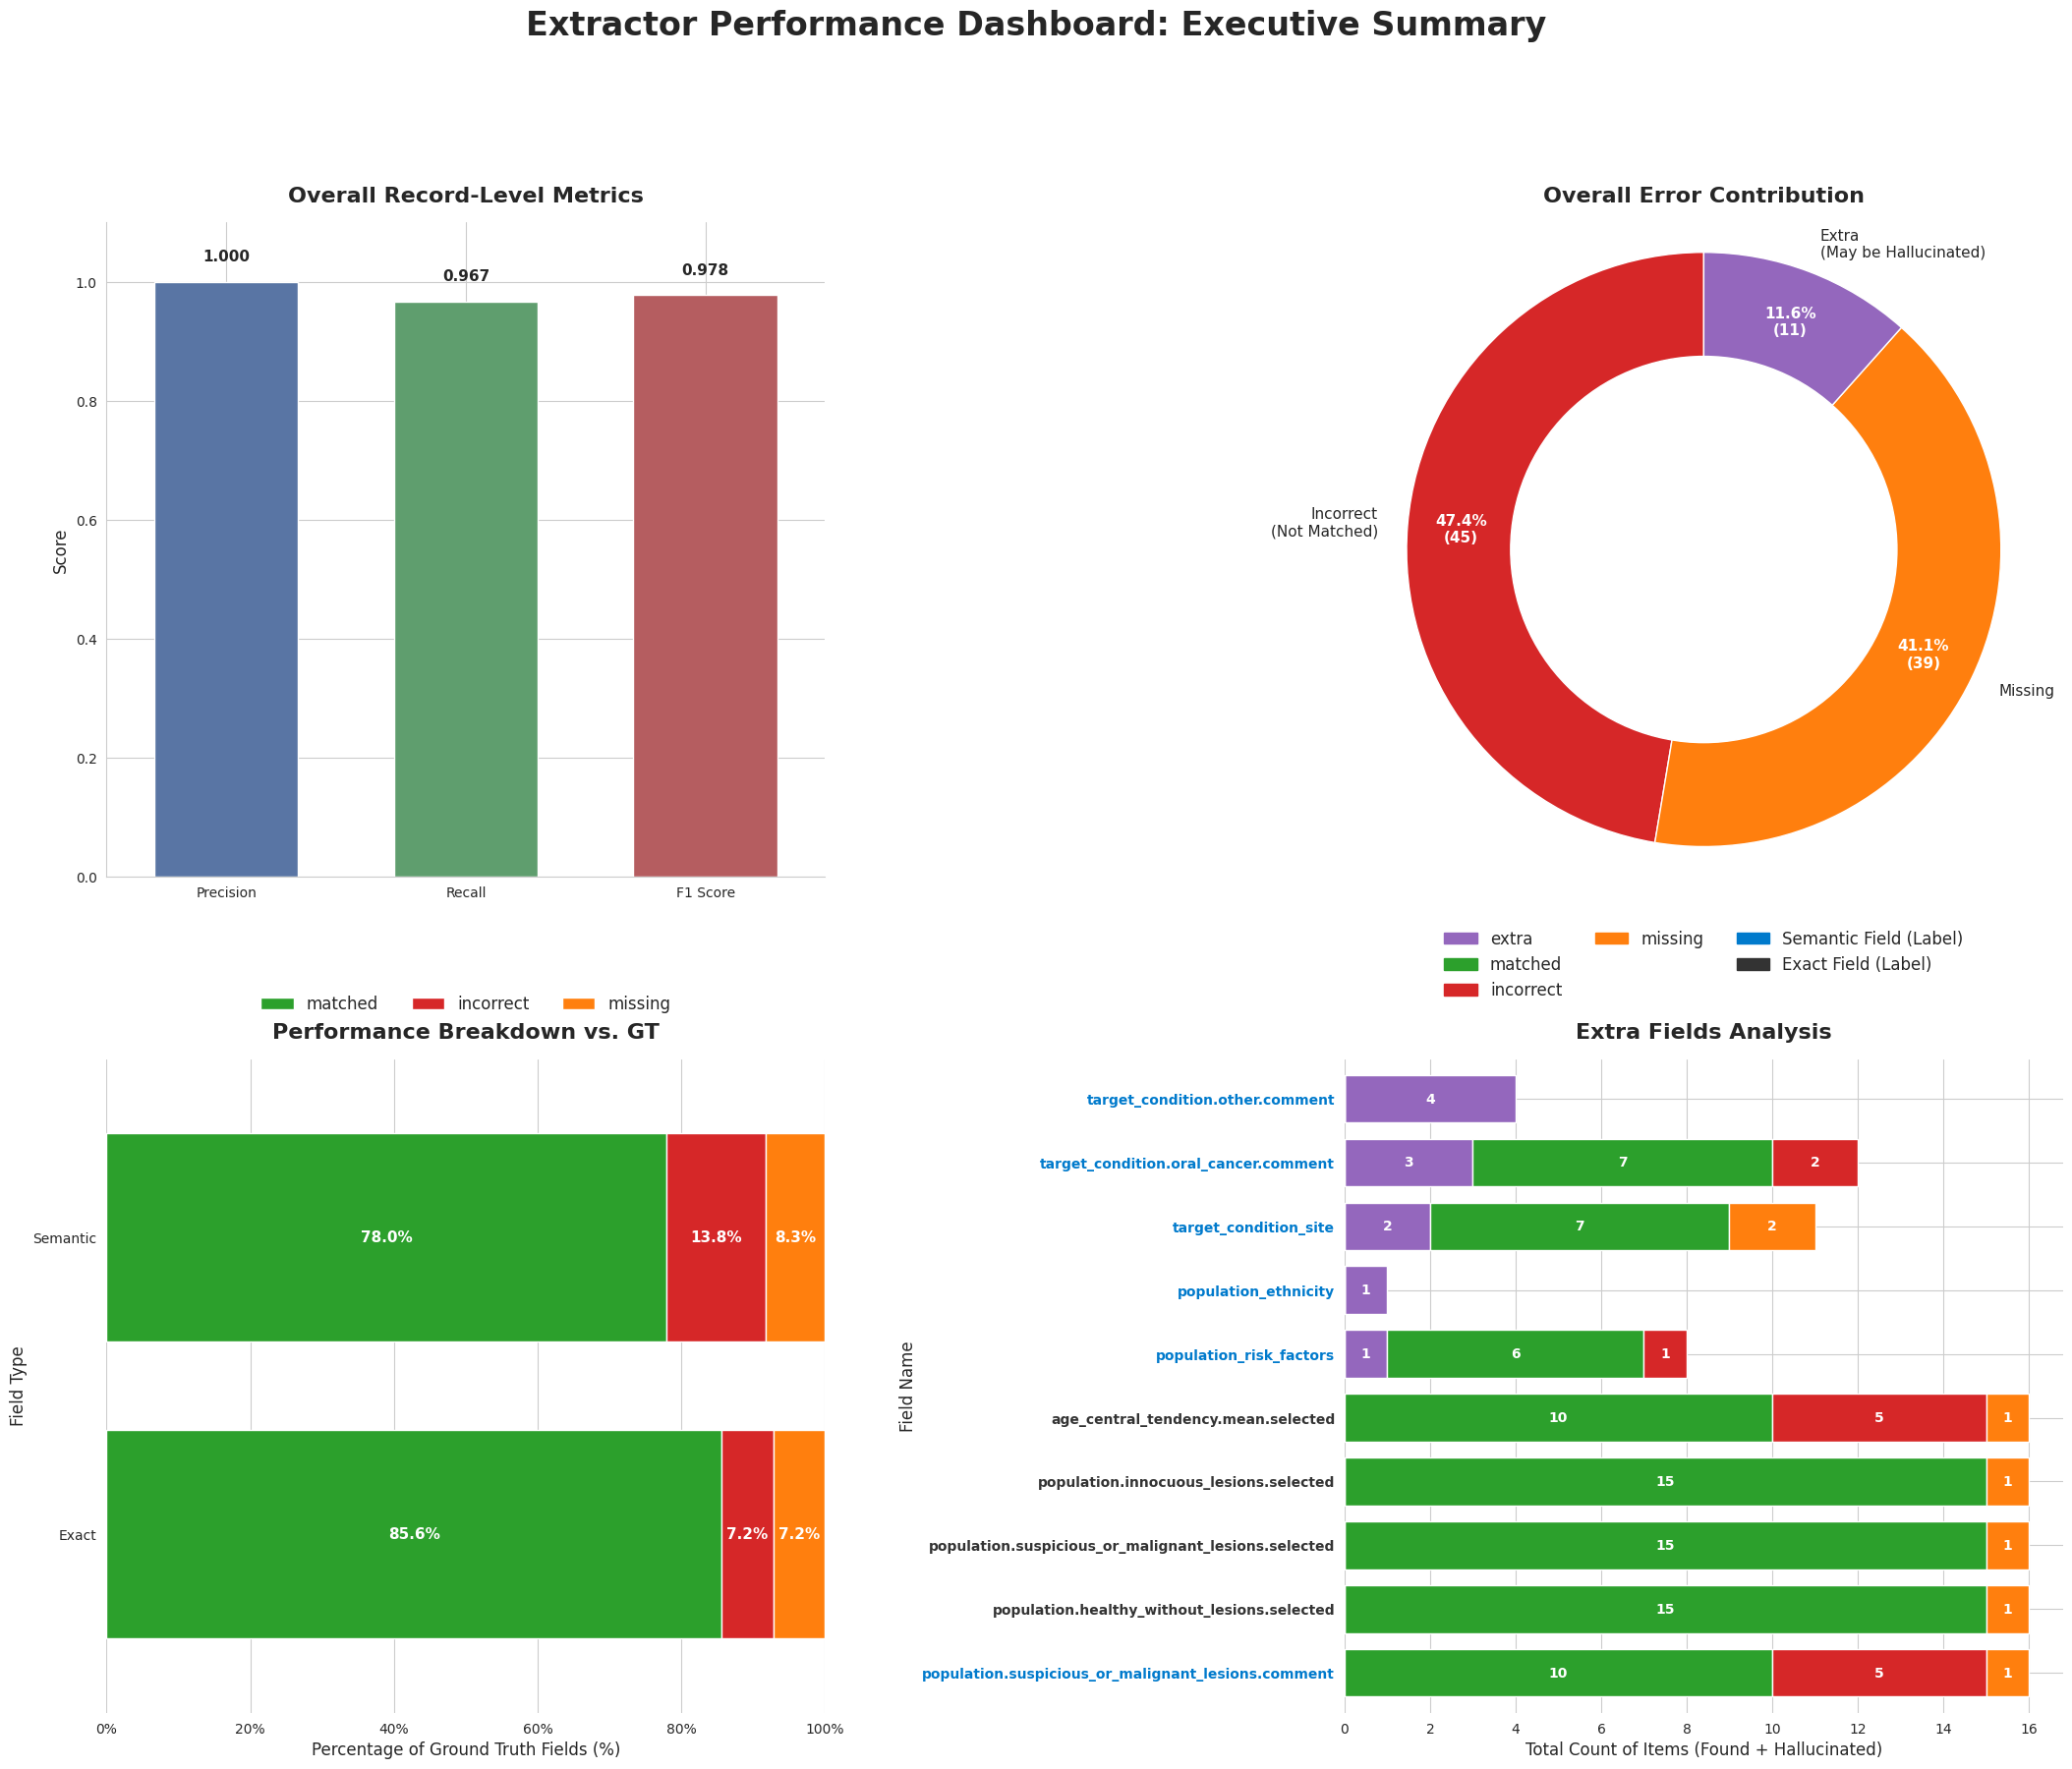

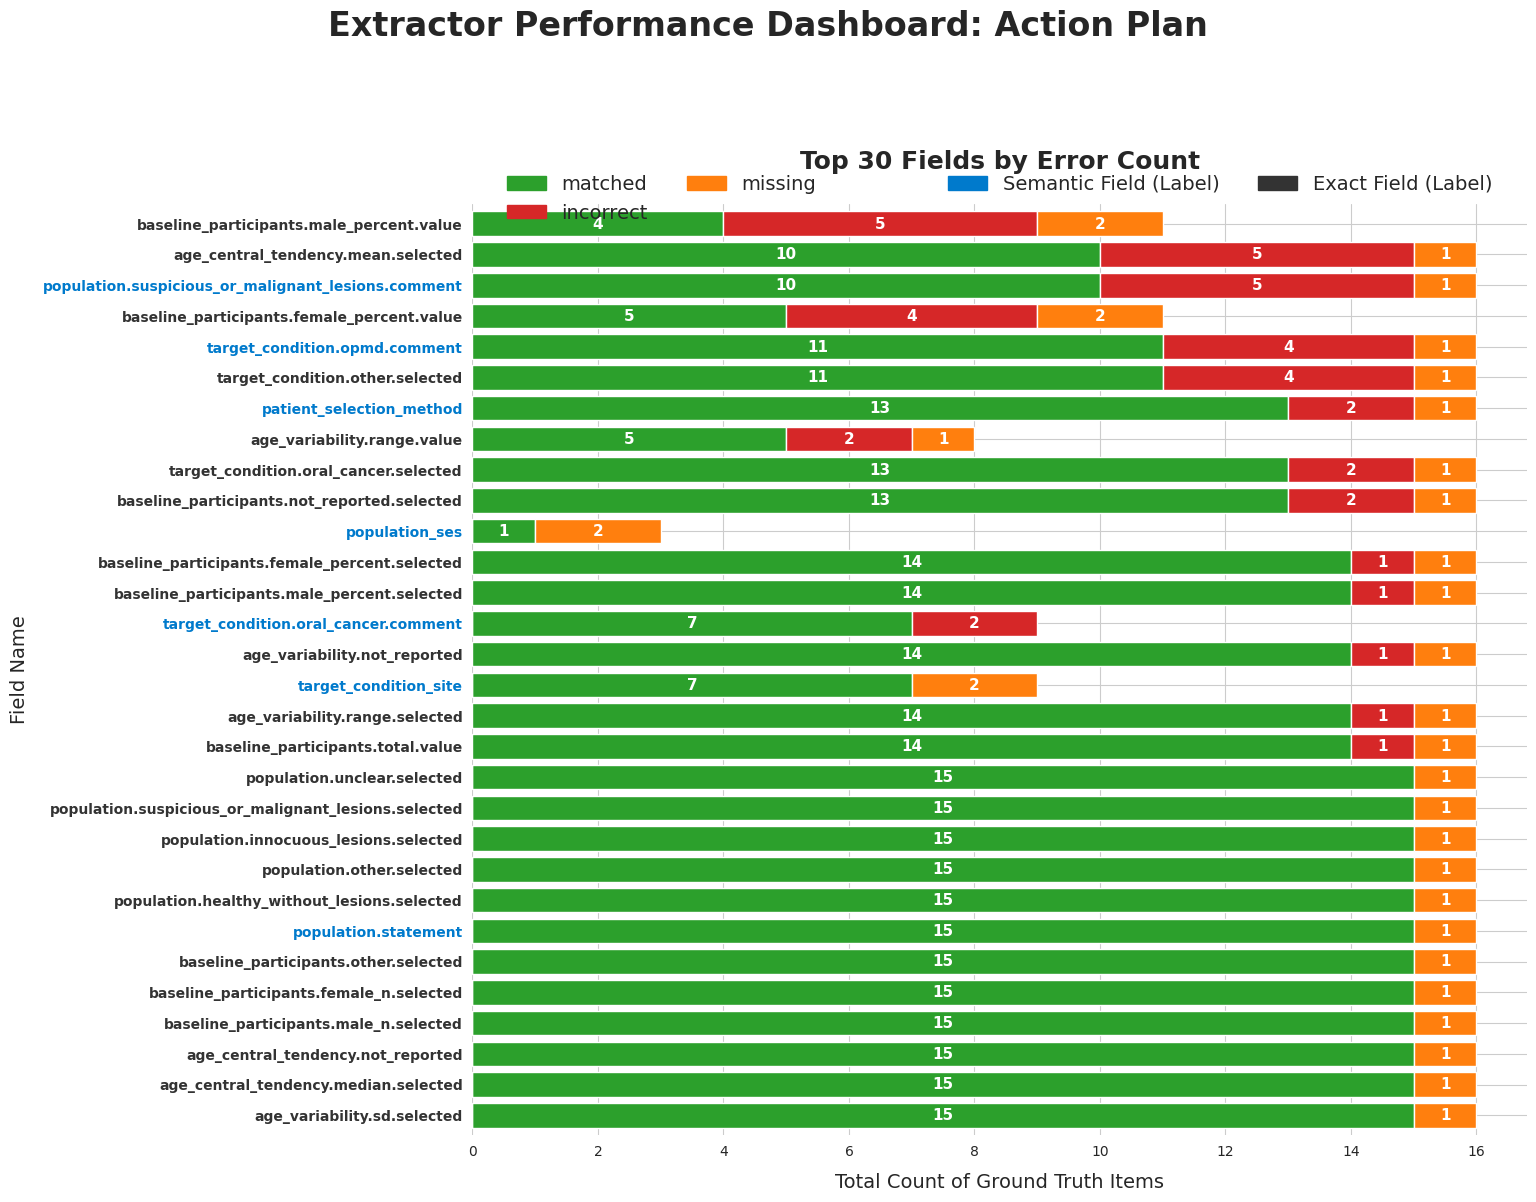


Completed running on examples and generating dashboards.


In [79]:
# ===================================================================
# FINAL AGGREGATION, PLOTTING, AND PRINTING (DASHBOARD)
# ===================================================================

# --- 1. Calculate final average metrics ---
avg_precision = sum(precision_scores) / len(precision_scores)
avg_recall = sum(recall_scores) / len(recall_scores)
avg_f1 = sum(f1_scores) / len(f1_scores)
avg_completeness = sum(completeness_scores) / len(completeness_scores)
final_counts = dict(aggregated_field_counts)

print(f"\n{'='*60}")
print(f"FINAL SUMMARY ACROSS {len(f1_scores)} EXAMPLES")
print(f"{'='*60}")
print(f"Average Precision: {avg_precision:.3f}")
print(f"Average Recall: {avg_recall:.3f}")
print(f"Average F1 Score: {avg_f1:.3f}")
print(f"Average Completeness: {avg_completeness:.1%}")

# --- 2. Print the final summary table (as you had before) ---
print("Final Summary Table")
print_field_level_table(final_counts)

# --- 3. Generate the DASHBOARDS ---
create_performance_dashboards(
    aggregated_field_counts=final_counts,
    avg_precision=avg_precision,
    avg_recall=avg_recall,
    avg_f1=avg_f1
)

print(f"\nCompleted running on examples and generating dashboards.")